In [2]:
import json
import os
import pandas as pd
import pprint
import time
import numpy as np

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping


try:
  from pyforest import *
except:
  !pip install pyforest
  from pyforest import *

print(tf.test.gpu_device_name())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11442946681801918949
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16866658369849635226
physical_device_desc: "device: XLA_CPU device"
]
[]


Using TensorFlow backend.


#### Provo con dimensionalità ridotta (time series fino alla 30)
#### aumento neuroni

In [4]:
#from google.colab import files

#uploaded = files.upload()
colab=True
if colab:
  !wget https://gitlab.com/DBertazioli/enercibiddding/raw/master/PyScripts/dumps/q_p_list_2015_2016.pickle

  with open("q_p_list_2015_2016.pickle", "rb") as infile:
    S=pickle.load(infile)
  !rm q_p_list_2015_2016.pickle
  
else:
  with open("dumps/q_p_list_2015_2016.pickle", "rb") as infile:
    S=pickle.load(infile)
  
S=S[:30]
print("len S is ", len(S))
#S1=S[1]
#S1.head()

#S1=pd.Series(S1)
S_series=[pd.Series(elem) for elem in S]
scaler = MinMaxScaler(feature_range=(0,1))
#S1 = scaler.fit_transform(S1.values.reshape(-1,1))

S=[scaler.fit_transform(S1.values.reshape(-1,1)) for S1 in S_series]
#S=S[:40]
#plt.plot(S1)
#X_train, X_test, y_train, y_test = train_test_split(S1[:-1], S1[1:], test_size=0.33, random_state=None, shuffle=False)

--2019-09-09 21:56:39--  https://gitlab.com/DBertazioli/enercibiddding/raw/master/PyScripts/dumps/q_p_list_2015_2016.pickle
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6501131 (6,2M) [application/octet-stream]
Saving to: ‘q_p_list_2015_2016.pickle’

q_p_list_2015_2016. 100%[===================>]   6,20M  5,55MB/s    in 1,1s    

2019-09-09 21:56:41 (5,55 MB/s) - ‘q_p_list_2015_2016.pickle’ saved [6501131/6501131]

len S is  30


In [5]:
#Callback function for online plot while fitting

from IPython.display import clear_output


class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        n_step=50
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses)%n_step==0:
            
            %matplotlib inline
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch+1))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

In [6]:
def split_multi_sequence(seq_list, n_steps, n_target_serie):
    main_X, main_y, X, y = list(), list(), list(),list()
    target_seq=seq_list[n_target_serie]
    append=True
    for i in range(len(target_seq)):
        X=[]
        y=[]
        for sequence in seq_list:
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the sequence
            if end_ix > len(sequence)-1:
                append=False
                break
            else:
                append=True
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
            X.append(np.array(seq_x))
            y.append(seq_y)
        if append==True:
            main_X.append(np.array(X))
            main_y.append(y)
    #return np.array(X), np.array(y)
    return main_X, main_y

In [7]:
def shaper(X):
    arr=np.ndarray(shape=(len(X),X[0].shape[1],X[0].shape[0]))
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            for k in range(arr.shape[2]):
                    try:
                        arr[i][j][k]=X[i][k][j]
                    except Exception as e:
                        print(e)
                        print(i,j,k)
                        #break
    return arr

In [8]:
len(S[1])

14160

In [13]:
# choose a number of time steps
n_steps = 168
n_target_serie=0
# split into samples
X, y = split_multi_sequence([elem[:-1000] for elem in S], n_steps,n_target_serie)
# reshape from [samples, timesteps] into [samples, timesteps, features]
#X=np.ndarray(X, shape=(len(X), X[0].shape[1], len(X)))

n_features = len(S)
#X = X.reshape((X.shape[0], X.shape[1], n_features))
#X = X.reshape((X.shape[0], X[0].shape[1], n_features))
X=shaper(X)
y=np.array(y)
#X
#y[0]

y=y.reshape(y.shape[0],y.shape[1])
#y.shape


Xt, yt=split_multi_sequence([elem[-1000:] for elem in S], n_steps, n_target_serie)
Xt=shaper(Xt)
#Xt = Xt.reshape((Xt.shape[0], Xt.shape[1], n_features))
#yt=S1[-100+1:]

In [9]:
!ls

2016_17
dates_2015_2016.pickle
dumps
Exploration_2015_2016.ipynb
lstm_models
LSTM_multivar_multidim_2015_bigger_timestep_168.ipynb
LSTM_multivar_multidim_2015.ipynb
LSTM_multivar_multidim_2015_no_zeros.ipynb
LSTM_multivar_multidim_2015_timestep_168.ipynb
LSTM_univar_2015.ipynb
old
Pre-processing_2015_2016.ipynb
time_series_prediction_idea.png


In [14]:
custom_model_name="LSTM_multivar_multidim_2015_bigger_timestep_168_1cycle_10000ep"

load=False
colab=True
if load:
    from keras.models import model_from_json
    
    if colab:
        from google.colab import files
        files.upload()
        model_name=custom_model_name
    else:
      model_name="lstm_models/LSTM_multivar_multidim_2015_timestep_168_3cycle_10000ep_512b"
    model_weights=model_name+"_weigths.h5.csv"

    json_file = open(model_name+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_weights)
    print("Loaded model from disk")

    recompile=False
    if recompile:
      loaded_model.compile(loss='mse', optimizer="adam")
      model=loaded_model

define=False
if define:
  # define model
  model = Sequential()
  model.add(LSTM(204, activation='relu', input_shape=(n_steps, n_features),return_sequences=True,dropout=0.1))
  model.add(LSTM(units=51, activation='relu', return_sequences=True, dropout=0.1))
  model.add(LSTM(units=25, activation='relu',dropout=0.1))
  model.add(Dense(units=102, activation="relu"))
  model.add(Dense(units=51, activation="softmax"))
  #model.compile(loss='mean_squared_error', optimizer=tf.train.AdamOptimizer())#, metrics=["acc"])
  model.compile(loss='mae', optimizer="adam")#, metrics=["acc"])



In [15]:
def unwind_y(arr_y, n_target_feature=0):
    return np.array([e[n_target_feature] for e in arr_y])

In [19]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, GRU, CuDNNLSTM
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, Nadam
from time import time
#!pip install livelossplot
#from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

define=True
if define:
  look_back=n_steps
  def create_model():
      model = Sequential()
      model.add(CuDNNLSTM(200, input_shape=(look_back, n_features), return_sequences=True, kernel_initializer='TruncatedNormal'))
      model.add(BatchNormalization())
      model.add(LeakyReLU())
      model.add(Dropout(rate=0.1))

      #1
      for _ in range(1):
          model.add(CuDNNLSTM(200, kernel_initializer='TruncatedNormal', return_sequences=True))
          model.add(BatchNormalization())
          model.add(LeakyReLU())
          model.add(Dropout(rate=0.1))   

      #2
      model.add(CuDNNLSTM(168, kernel_initializer='TruncatedNormal', return_sequences=False))
      model.add(BatchNormalization())
      model.add(LeakyReLU())
      model.add(Dropout(rate=0.1))

      #3
      for _ in range(0):
          model.add(Dense(32))
          model.add(BatchNormalization())
          model.add(LeakyReLU())
          model.add(Dropout(rate=0.1))
      #3
      for _ in range(1):
          model.add(Dense(256))
          model.add(BatchNormalization())
          model.add(LeakyReLU())
          model.add(Dropout(rate=0.1))
      #4
      for _ in range(1):
          model.add(Dense(128, kernel_initializer='TruncatedNormal'))
          model.add(BatchNormalization())
          model.add(LeakyReLU())
          model.add(Dropout(rate=0.1))

      #5
      model.add(Dense(n_features))

      return model

  model1=create_model()
else:
  model1=model




In [20]:
epochs = 10**2
bs = 512
lr = 1e-1#5e-2

# 0.05 0.9 0 True
#sgd = SGD(lr=0.5, momentum=0.9, decay=0, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower
adam = Adam(lr=lr)
nadam = Nadam(lr=lr)

# compile & fit
model1.compile(optimizer='adam', loss = ['mse'], metrics=["mae", 'mse'])



In [21]:
model1.summary()
history_list=[]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_10 (CuDNNLSTM)    (None, 168, 200)          185600    
_________________________________________________________________
batch_normalization_10 (Batc (None, 168, 200)          800       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 168, 200)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 168, 200)          0         
_________________________________________________________________
cu_dnnlstm_11 (CuDNNLSTM)    (None, 168, 200)          321600    
_________________________________________________________________
batch_normalization_11 (Batc (None, 168, 200)          800       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 168, 200)          0         
__________

In [22]:
def save_to_disk(model1, cycle, colab=True, epochs=10000, batch=512):
  
  from keras.models import model_from_json
  if colab:
    model_name="LSTM_multivar_multidim_2015_bigger_timestep_168_"+str(cycle)+"cycle_"+str(epochs)+"ep_"+str(batch)+"b"
  else:
    model_name="lstm_models/LSTM_multivar_multidim_2015_bigger_timestep_168_"+str(cycle)+"cycle_"+str(epochs)+"ep_"+str(batch)+"b"
  model_weights=model_name+"_weigths.h5.csv"
  # serialize model to JSON
  model_json = model1.to_json()
  with open(model_name+".json", "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model1.save_weights(model_weights)
  print("Saved model to disk")

  if colab:
      from google.colab import files
      files.download(model_name+".json")
      files.download(model_weights)


In [23]:
history=model1.fit(X, y, epochs=10000, batch_size=512, verbose=2, callbacks=[plot_losses])
#print(model.summary())
#history_list.append(history)


#1 cycle of 10000 pretty good
#2 cycle as well
#saved weights
#3 cycle
#saved weights
#4 cycle
#saved weights
#5 cycle
#saved weights




Instructions for updating:
Use tf.cast instead.
Epoch 1/10000


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNN' used by node cu_dnnlstm_1/CudnnRNN (defined at /home/dario/.local/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py:517) with these attrs: [T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", is_training=true, seed2=0, dropout=0, seed=87654321]
Registered devices: [CPU, XLA_CPU]
Registered kernels:
  <no registered kernels>

	 [[node cu_dnnlstm_1/CudnnRNN (defined at /home/dario/.local/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py:517) ]]

Caused by op 'cu_dnnlstm_1/CudnnRNN', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/dario/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/dario/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/dario/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/dario/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/dario/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/dario/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/dario/.local/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/dario/.local/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/dario/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/dario/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/dario/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/dario/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/dario/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/dario/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/dario/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/dario/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/dario/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/dario/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "/home/dario/.local/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/dario/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/dario/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/dario/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-4389325ab7de>", line 64, in <module>
    model1=create_model()
  File "<ipython-input-16-4389325ab7de>", line 22, in create_model
    model.add(CuDNNLSTM(200, input_shape=(look_back, n_features), return_sequences=True, kernel_initializer='TruncatedNormal'))
  File "/home/dario/.local/lib/python3.6/site-packages/keras/engine/sequential.py", line 165, in add
    layer(x)
  File "/home/dario/.local/lib/python3.6/site-packages/keras/layers/recurrent.py", line 532, in __call__
    return super(RNN, self).__call__(inputs, **kwargs)
  File "/home/dario/.local/lib/python3.6/site-packages/keras/engine/base_layer.py", line 457, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/dario/.local/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 90, in call
    output, states = self._process_batch(inputs, initial_state)
  File "/home/dario/.local/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 517, in _process_batch
    is_training=True)
  File "/home/dario/.local/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1636, in __call__
    input_data, input_h, input_c, params, is_training=is_training)
  File "/home/dario/.local/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1527, in __call__
    seed=self._seed)
  File "/home/dario/.local/lib/python3.6/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1014, in _cudnn_rnn
    outputs, output_h, output_c, _ = gen_cudnn_rnn_ops.cudnn_rnn(**args)
  File "/home/dario/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_cudnn_rnn_ops.py", line 142, in cudnn_rnn
    seed2=seed2, is_training=is_training, name=name)
  File "/home/dario/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/dario/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/dario/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/dario/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): No OpKernel was registered to support Op 'CudnnRNN' used by node cu_dnnlstm_1/CudnnRNN (defined at /home/dario/.local/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py:517) with these attrs: [T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", is_training=true, seed2=0, dropout=0, seed=87654321]
Registered devices: [CPU, XLA_CPU]
Registered kernels:
  <no registered kernels>

	 [[node cu_dnnlstm_1/CudnnRNN (defined at /home/dario/.local/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py:517) ]]


In [0]:
cycle=0
try:
    print("saving model to disk at cycle ", cycle )
    save_to_disk(model1, cycle)
    print("model saved")
except Exception as e:
    print(e)
    print("trying again")
    try:
      save_to_disk(model1, cycle)
      print("model saved after trying again")
    except:
      print("passing")
      pass
  #history_list.append(history)

saving model to disk at cycle  bad_but_last
Saved model to disk
model saved


In [0]:
cycle=0
try:
    print("saving model to disk at cycle ", cycle )
    save_to_disk(model1, cycle)
    print("model saved")
except Exception as e:
    print(e)
    print("trying again")
    try:
      save_to_disk(model1, cycle)
      print("model saved after trying again")
    except:
      print("passing")
      pass
  #history_list.append(history)

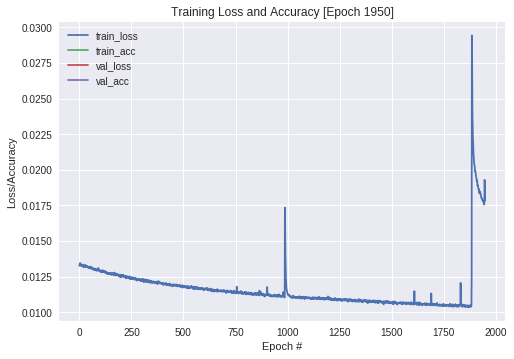

In [0]:
history=model1.fit(X, y, epochs=10000, batch_size=512, verbose=0, callbacks=[plot_losses])


In [0]:
cycle=1
try:
    print("saving model to disk at cycle ", cycle )
    save_to_disk(model1, cycle)
    print("model saved")
except Exception as e:
    print(e)
    print("trying again")
    try:
      save_to_disk(model1, cycle)
      print("model saved after trying again")
    except:
      print("passing")
      pass
history_list.append(history)

In [0]:
try:
    print("saving model to disk at cycle ", cycle )
    save_to_disk(model1, cycle)
    print("model saved")
except Exception as e:
    print(e)
    print("trying again")
    try:
      save_to_disk(model1, cycle)
      print("model saved after trying again")
    except:
      print("passing")
      pass

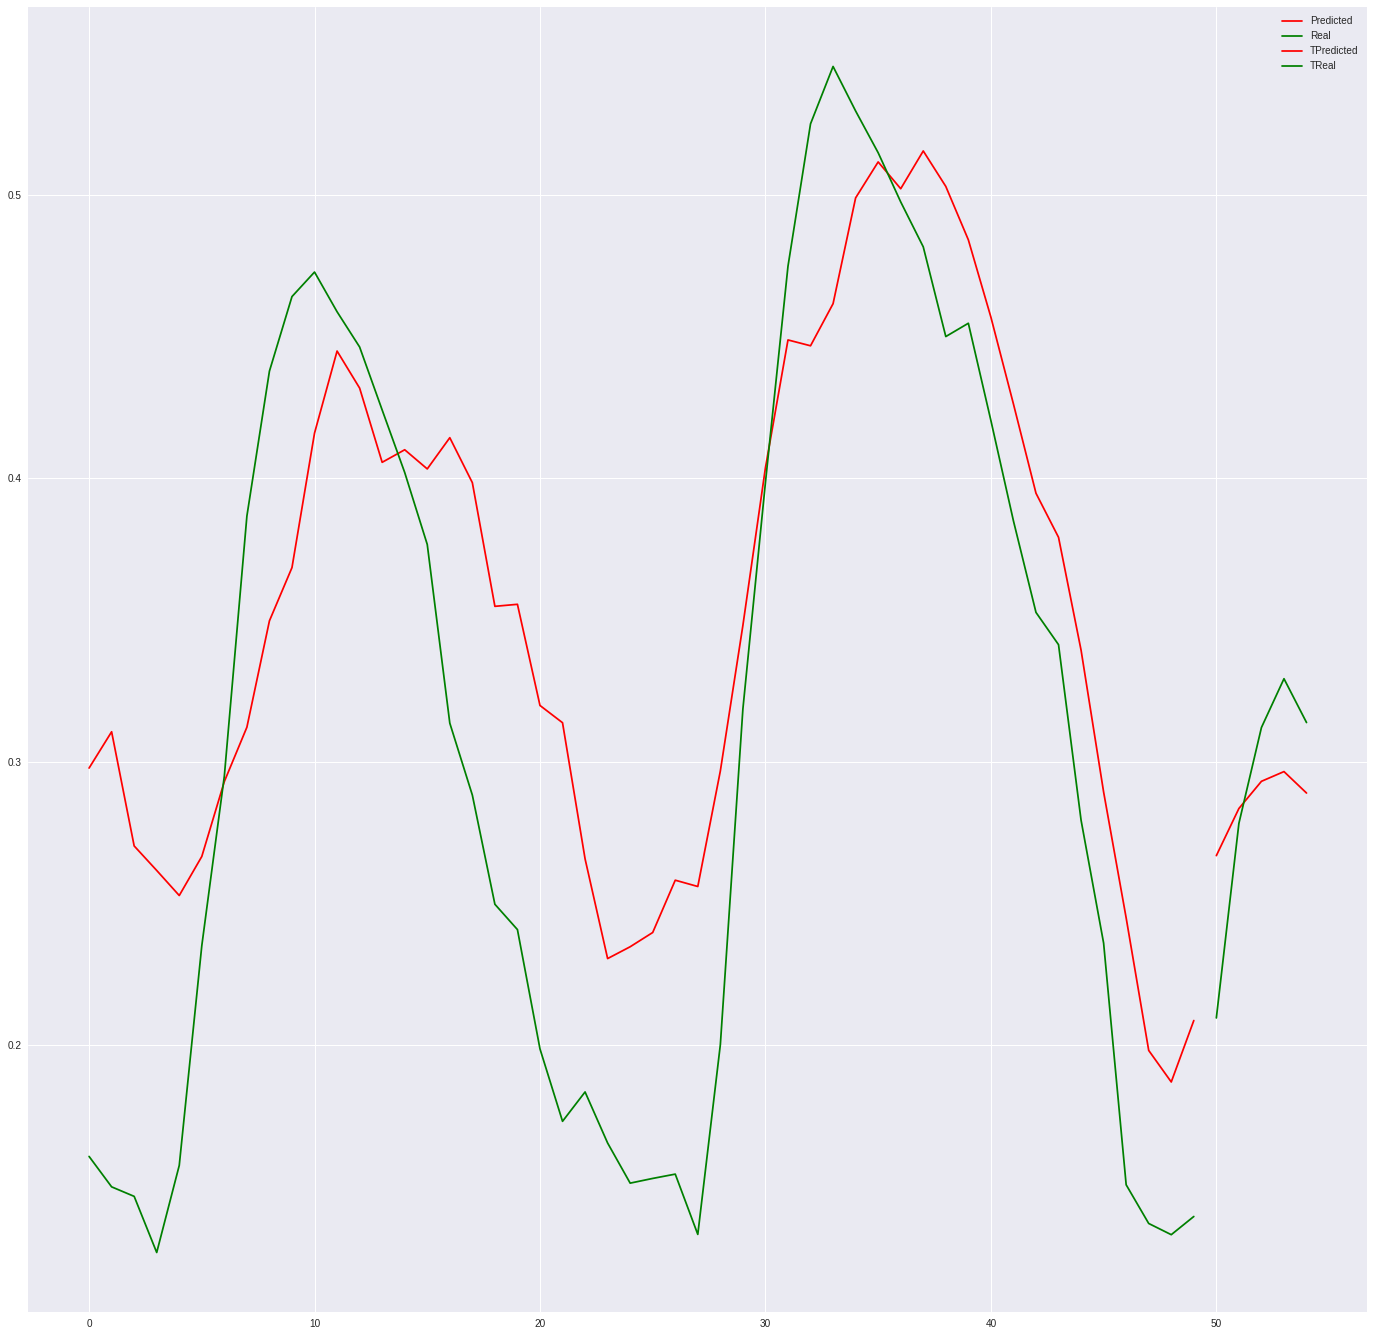

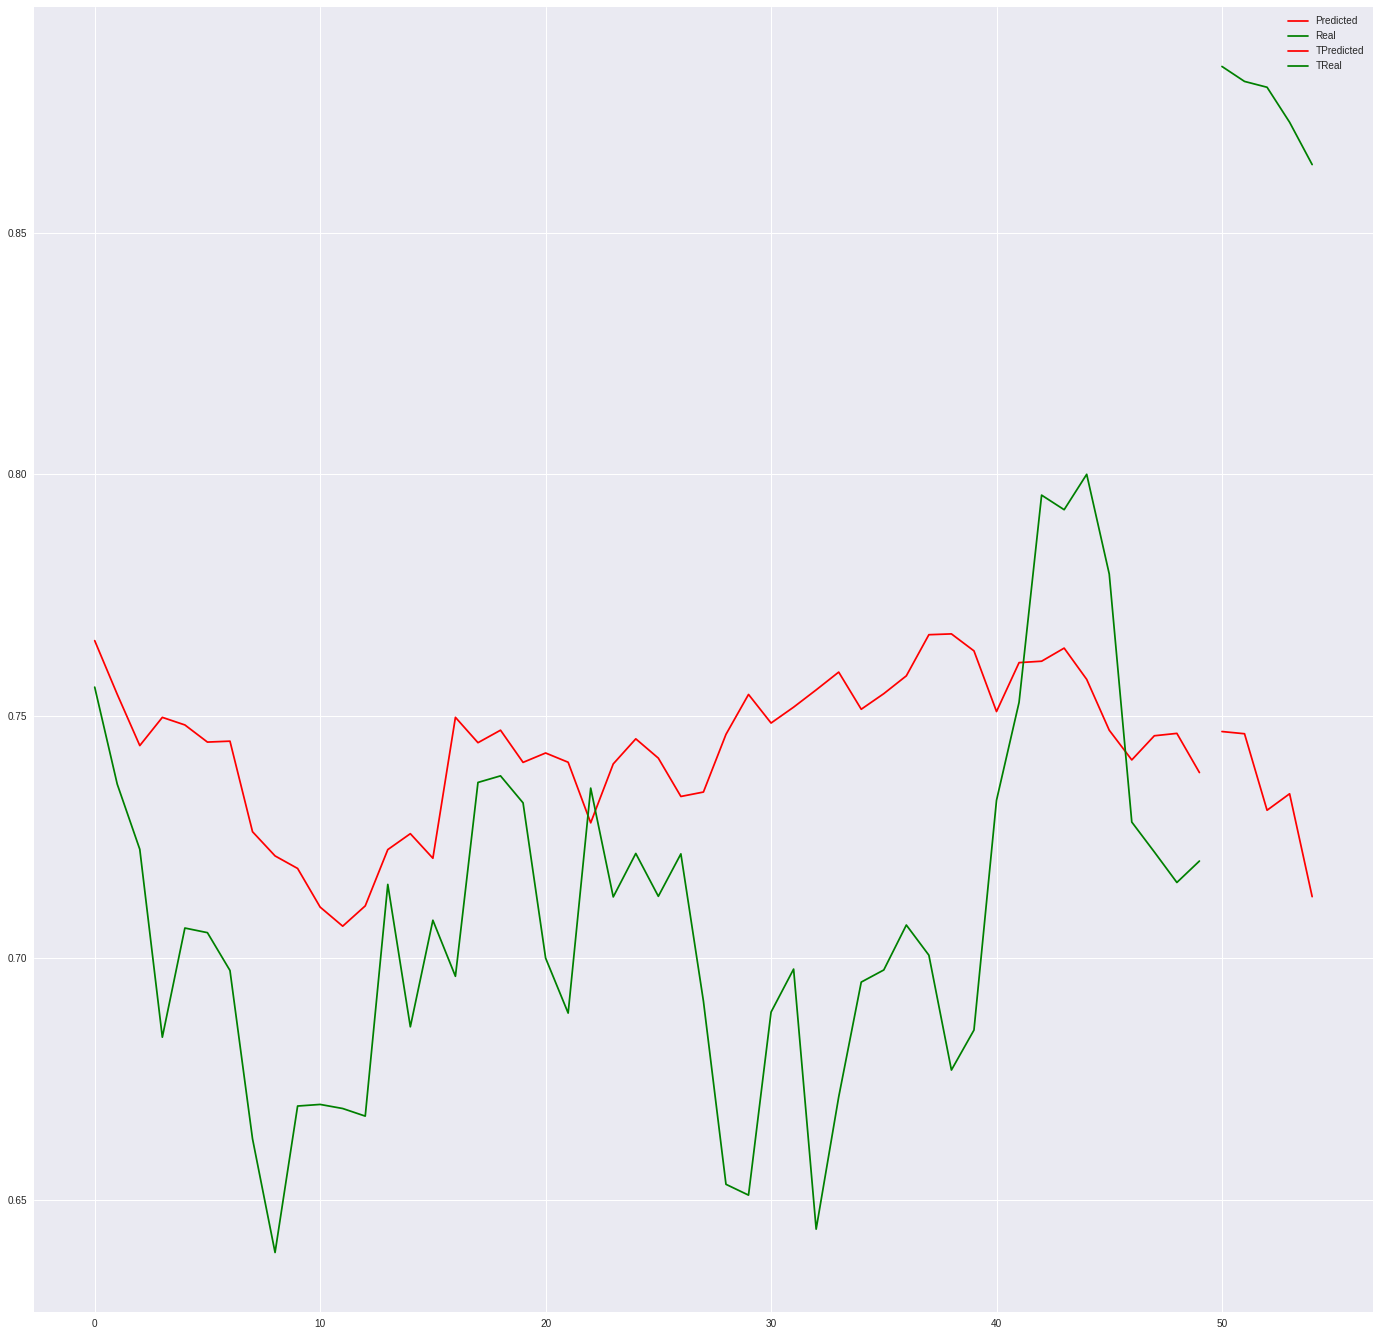

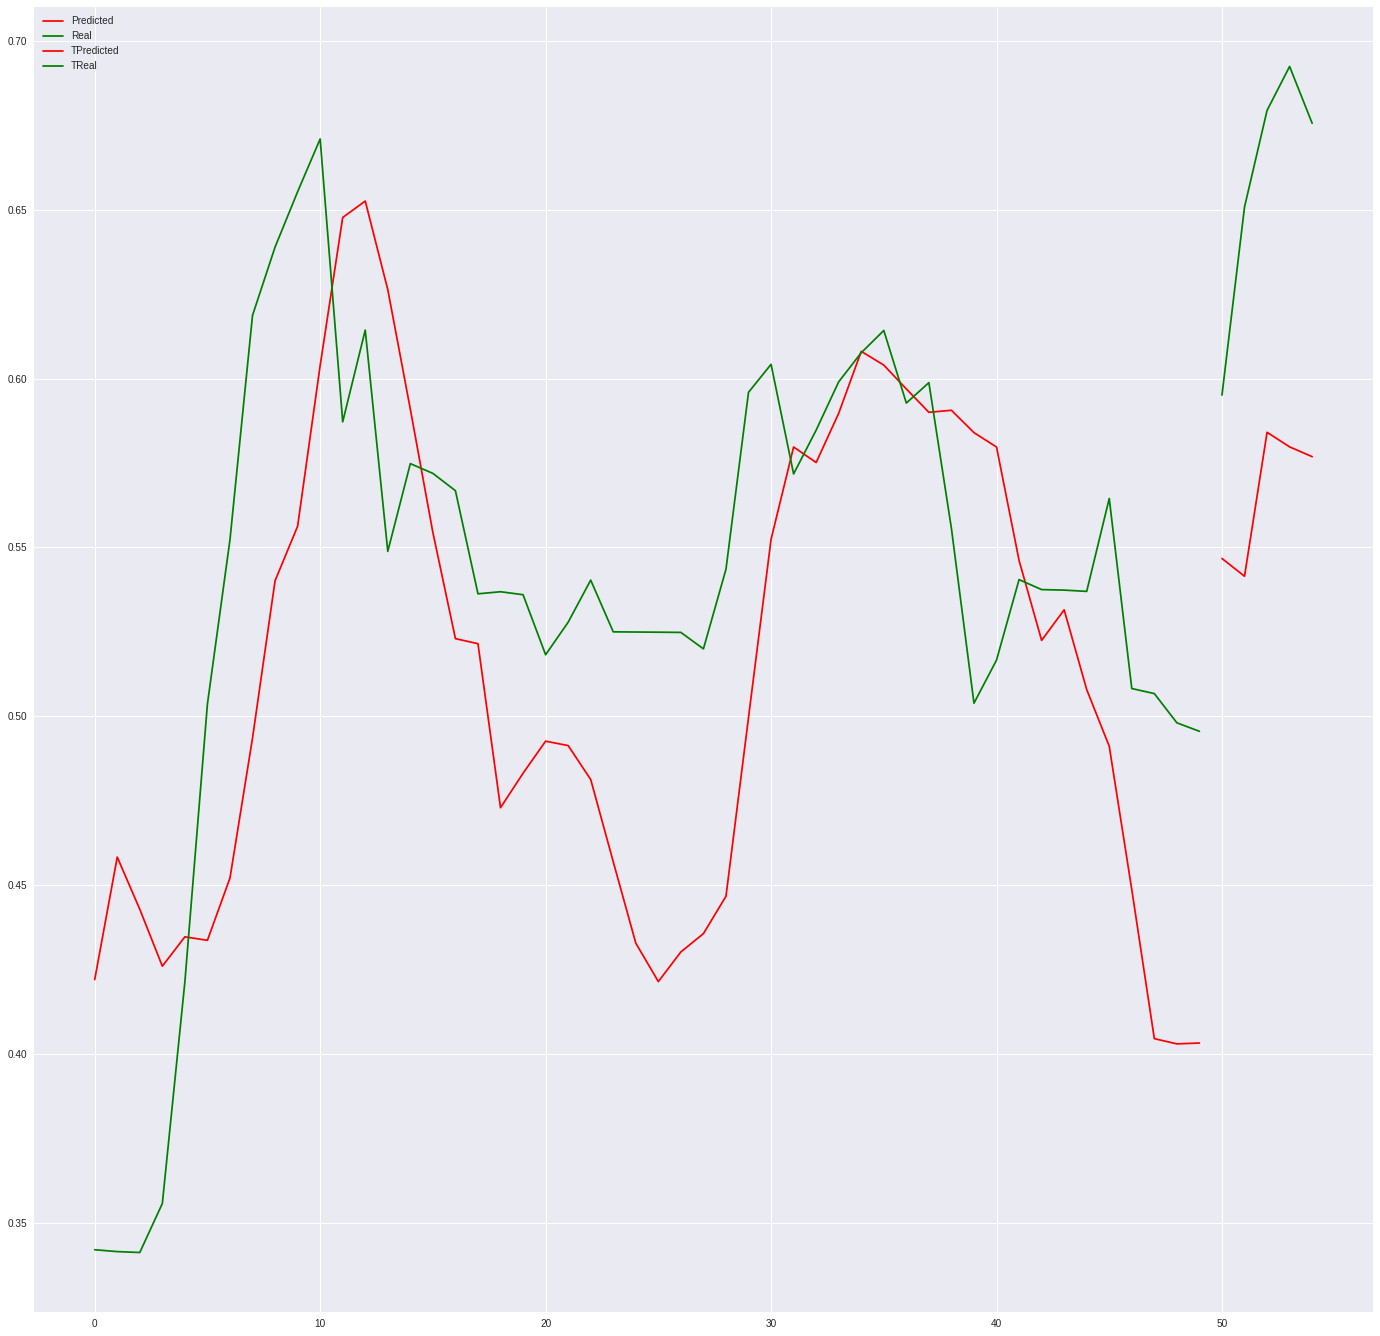

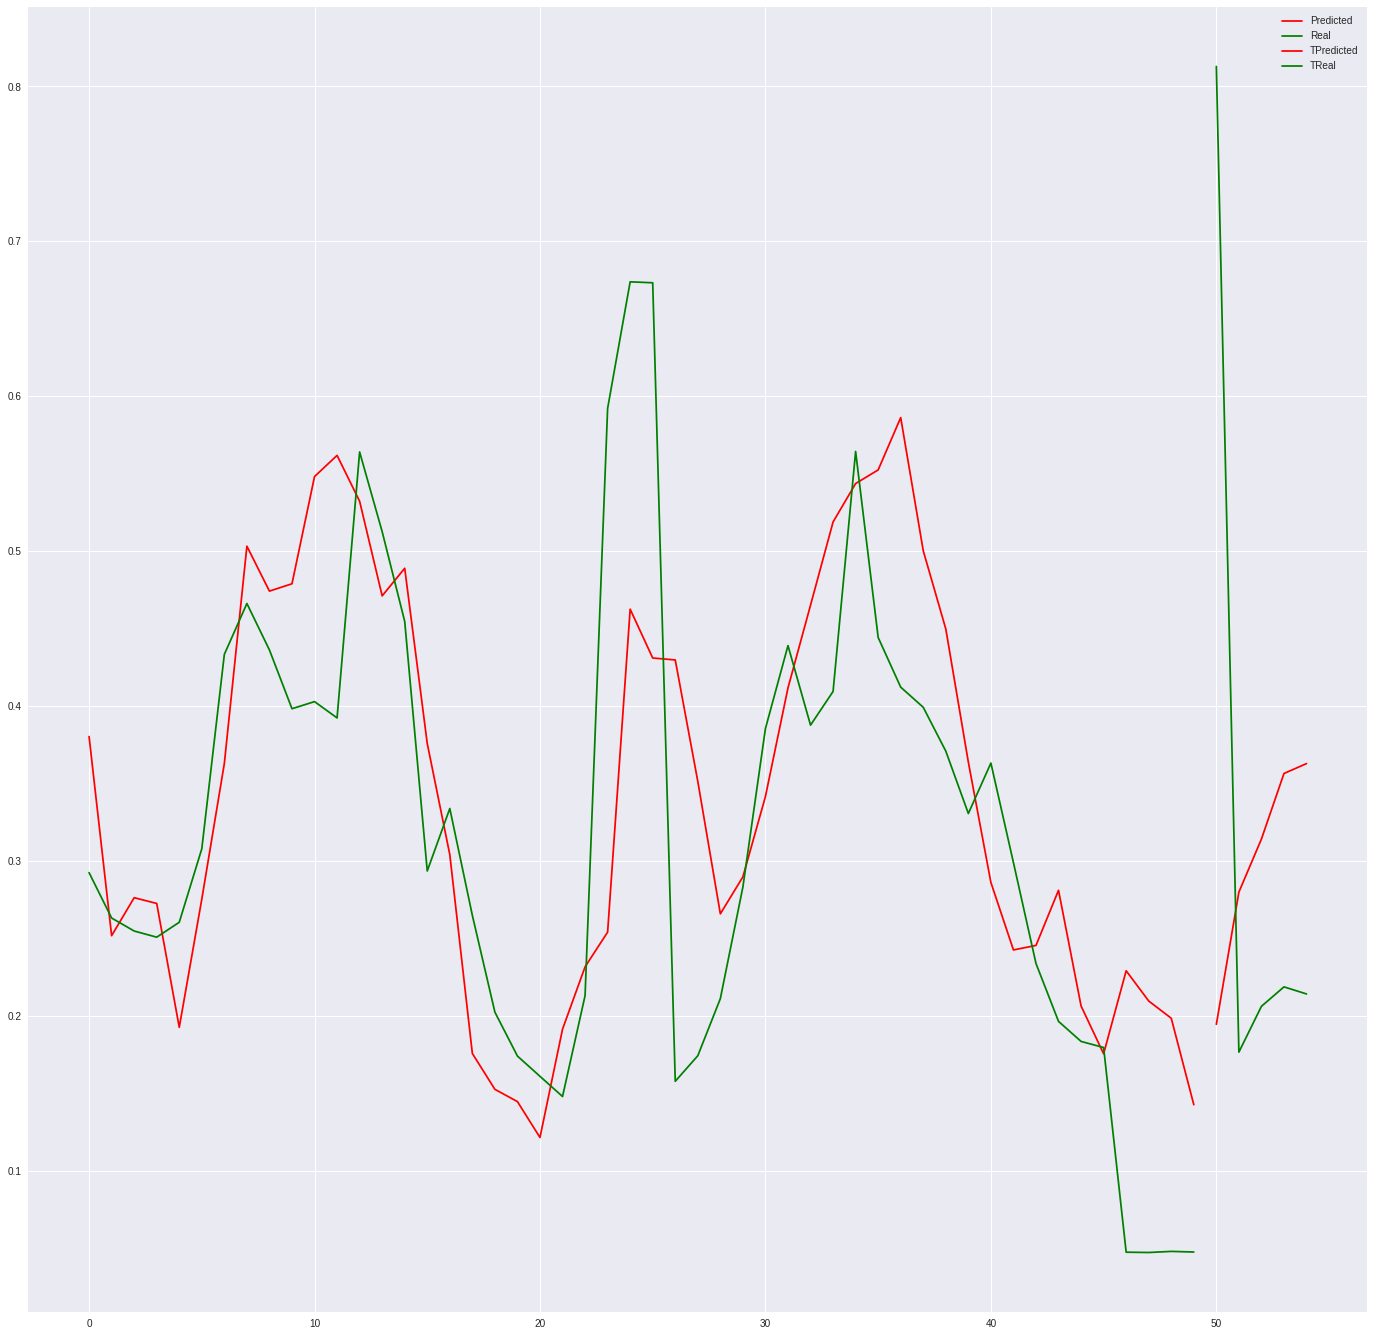

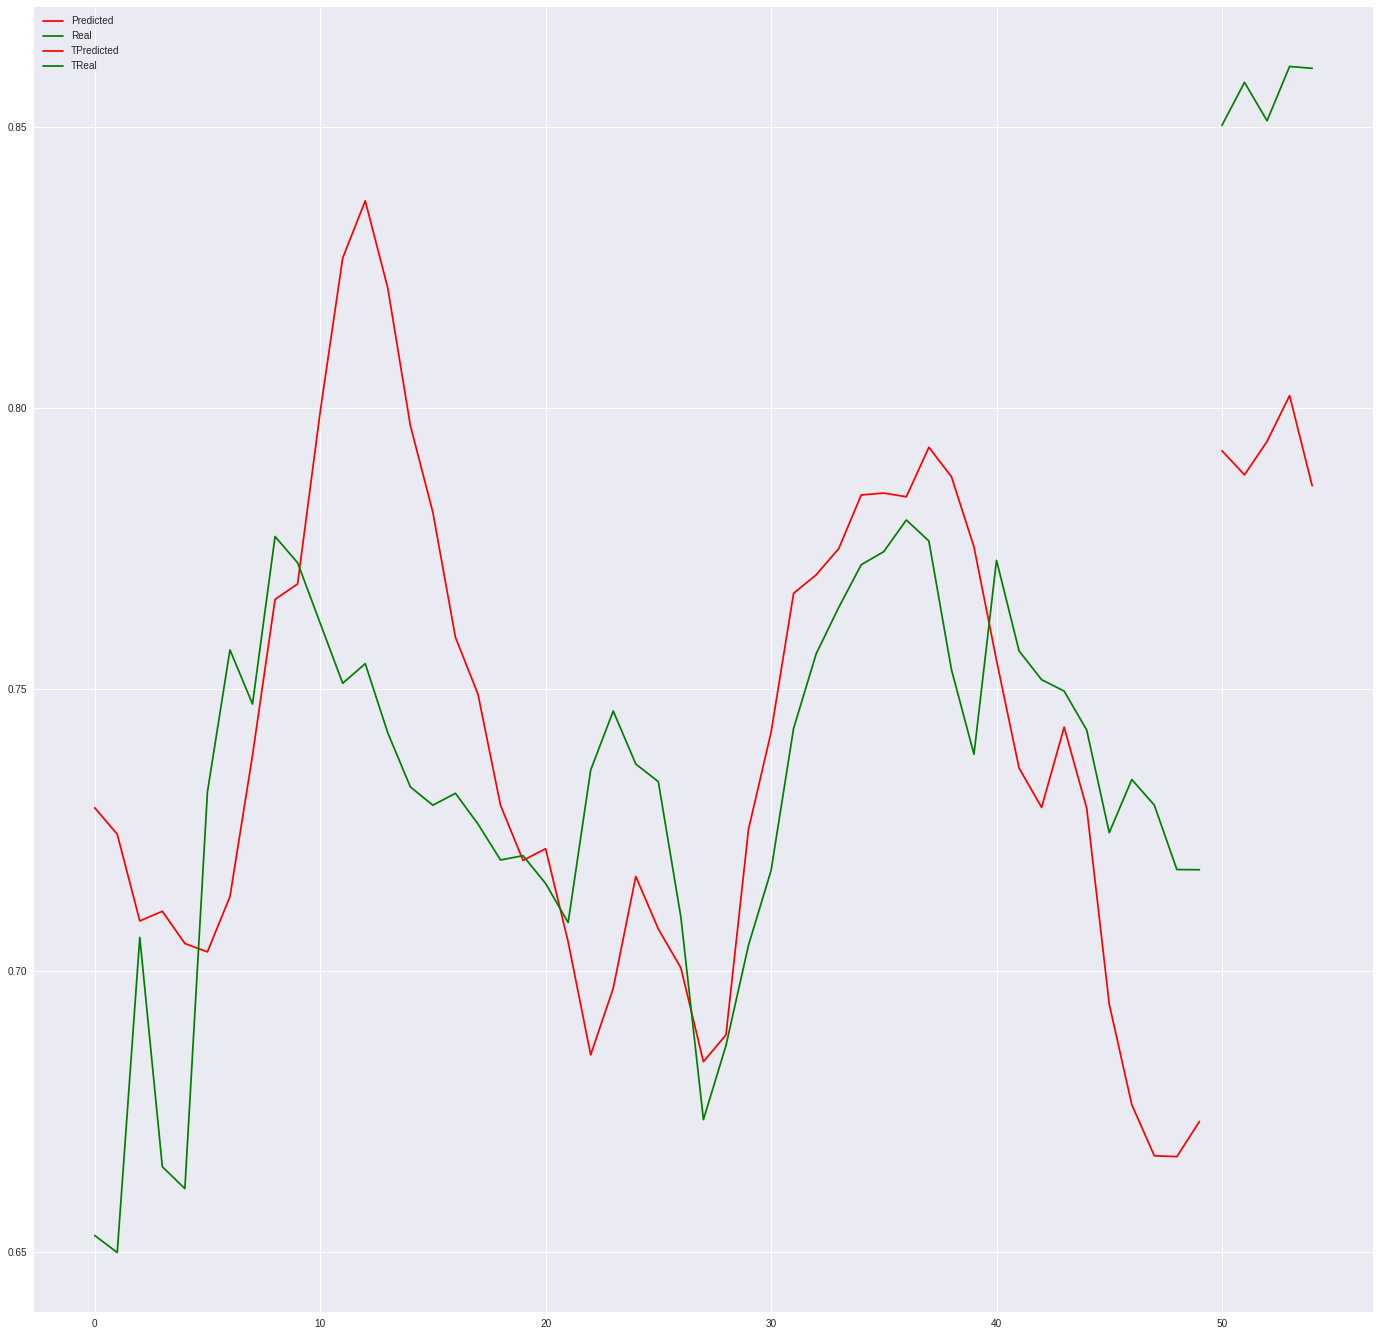

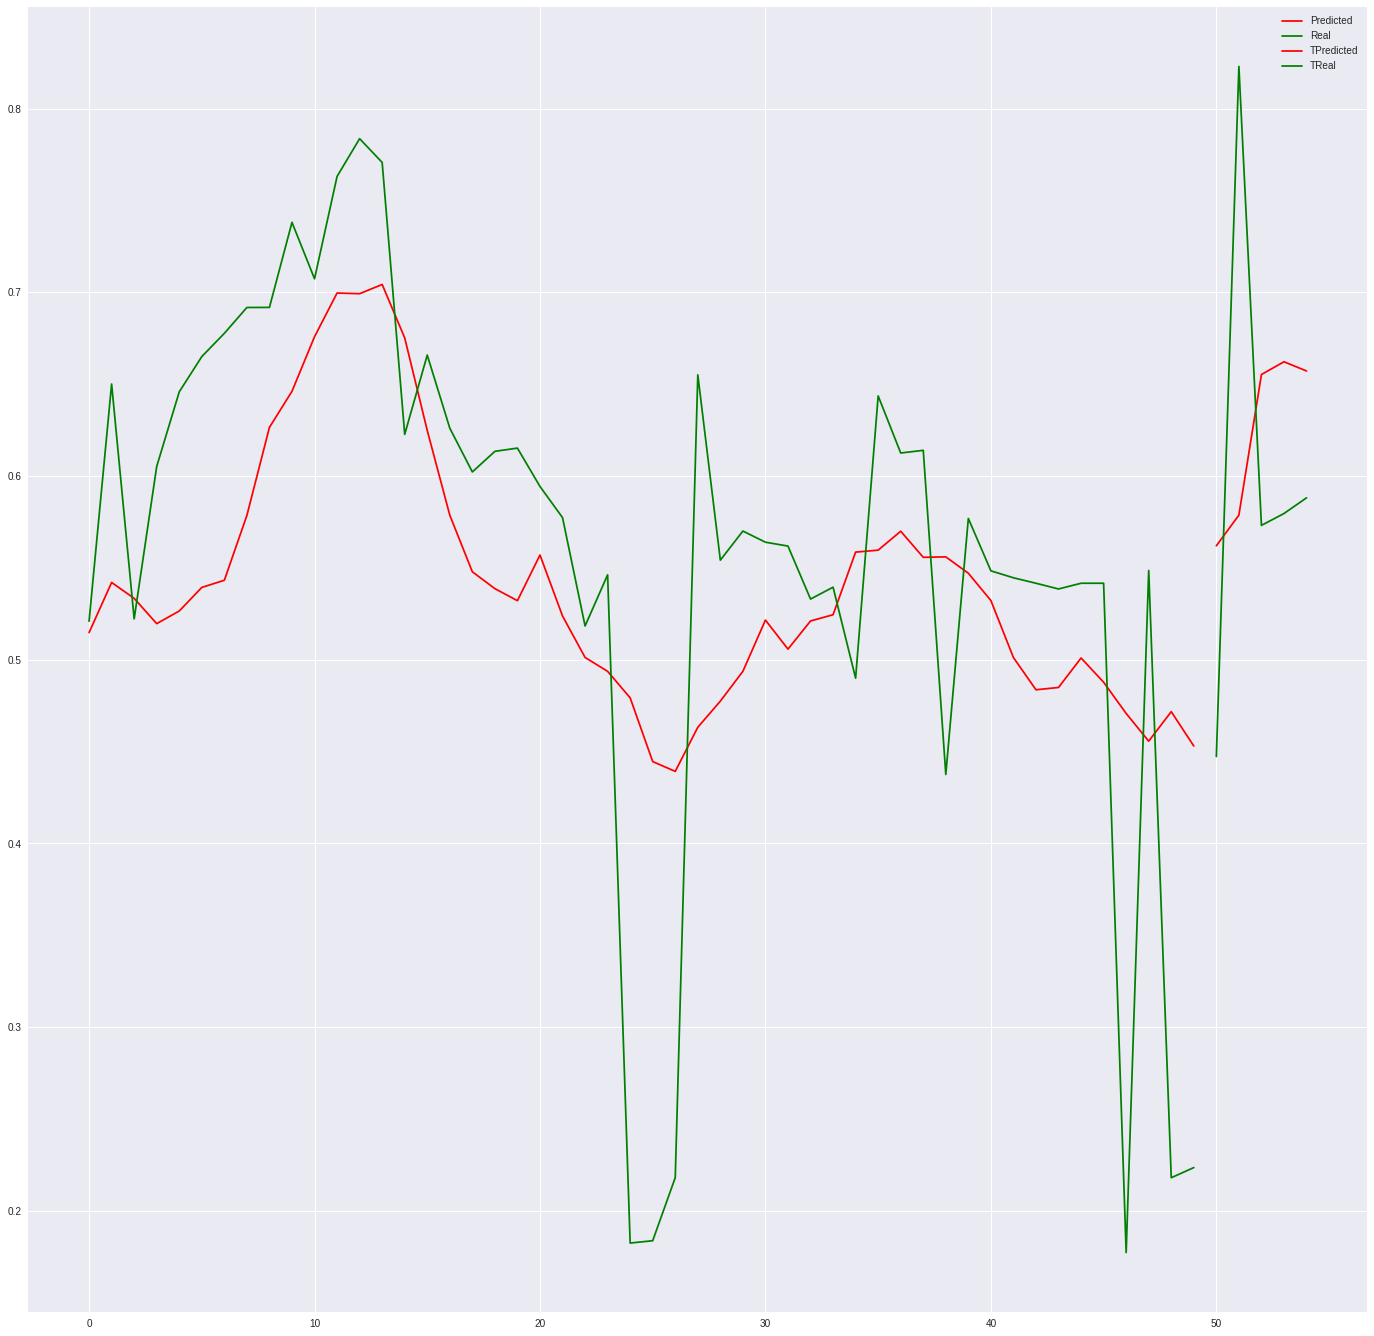

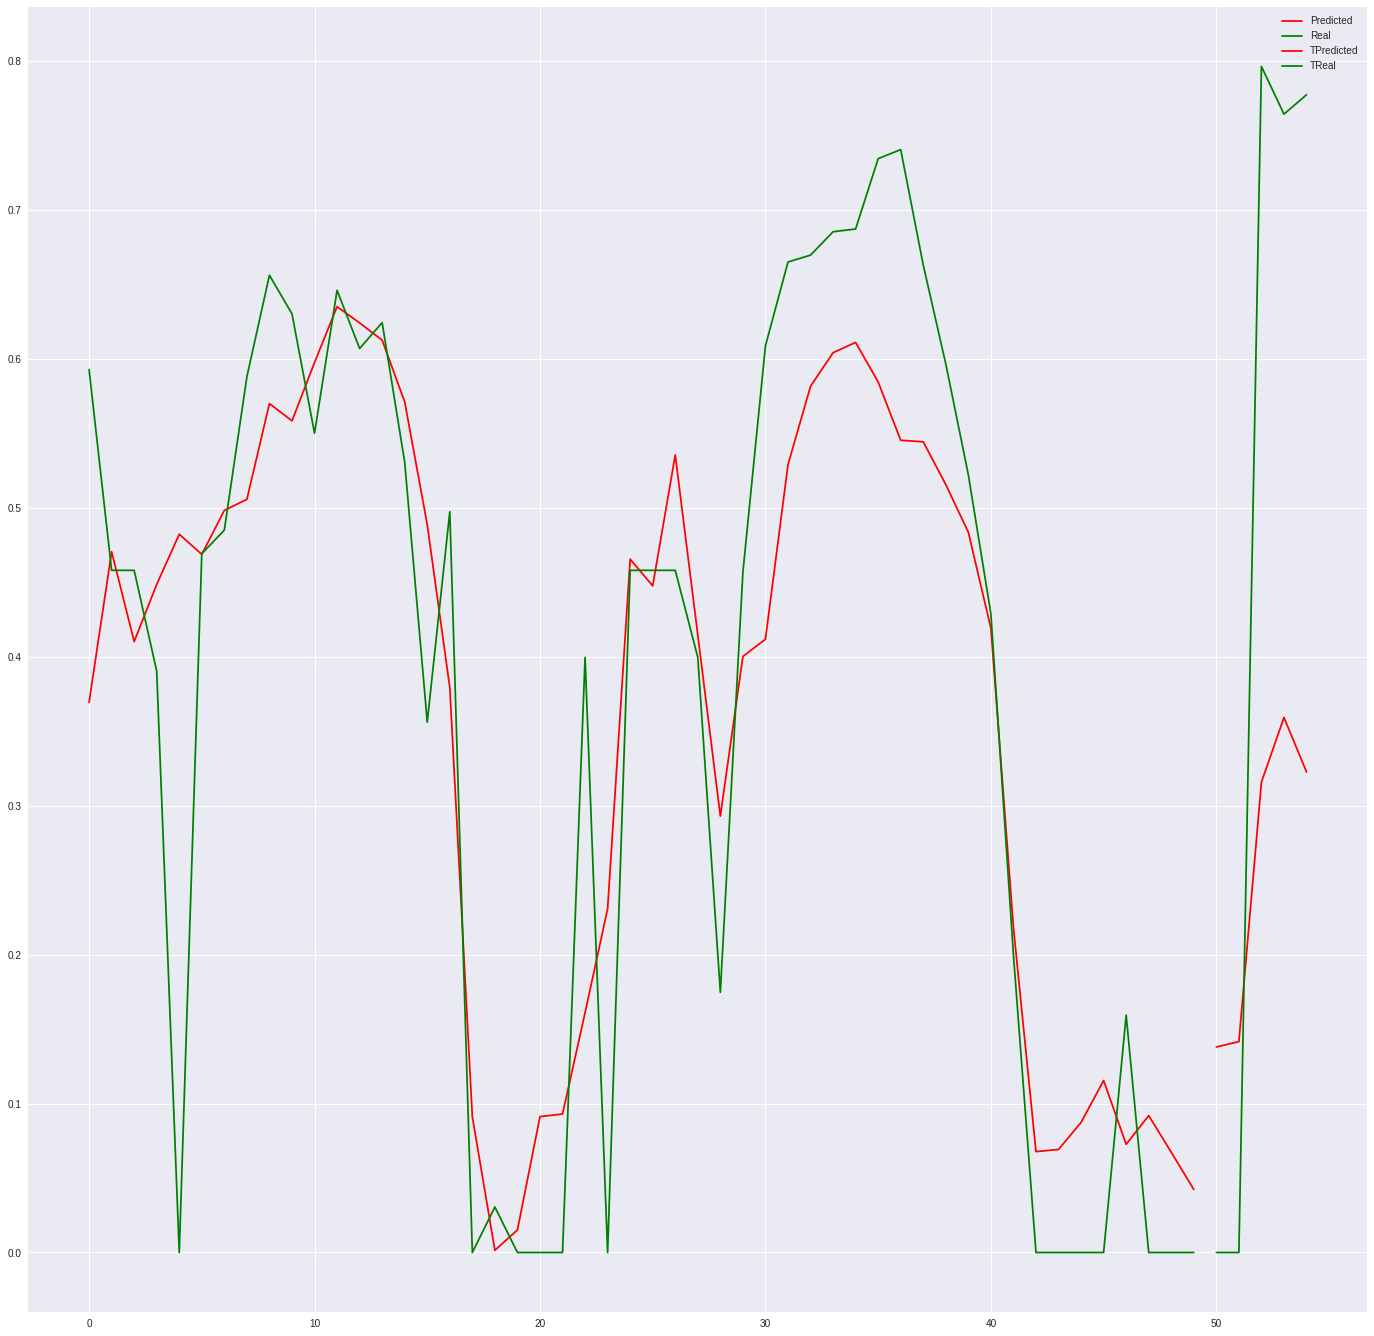

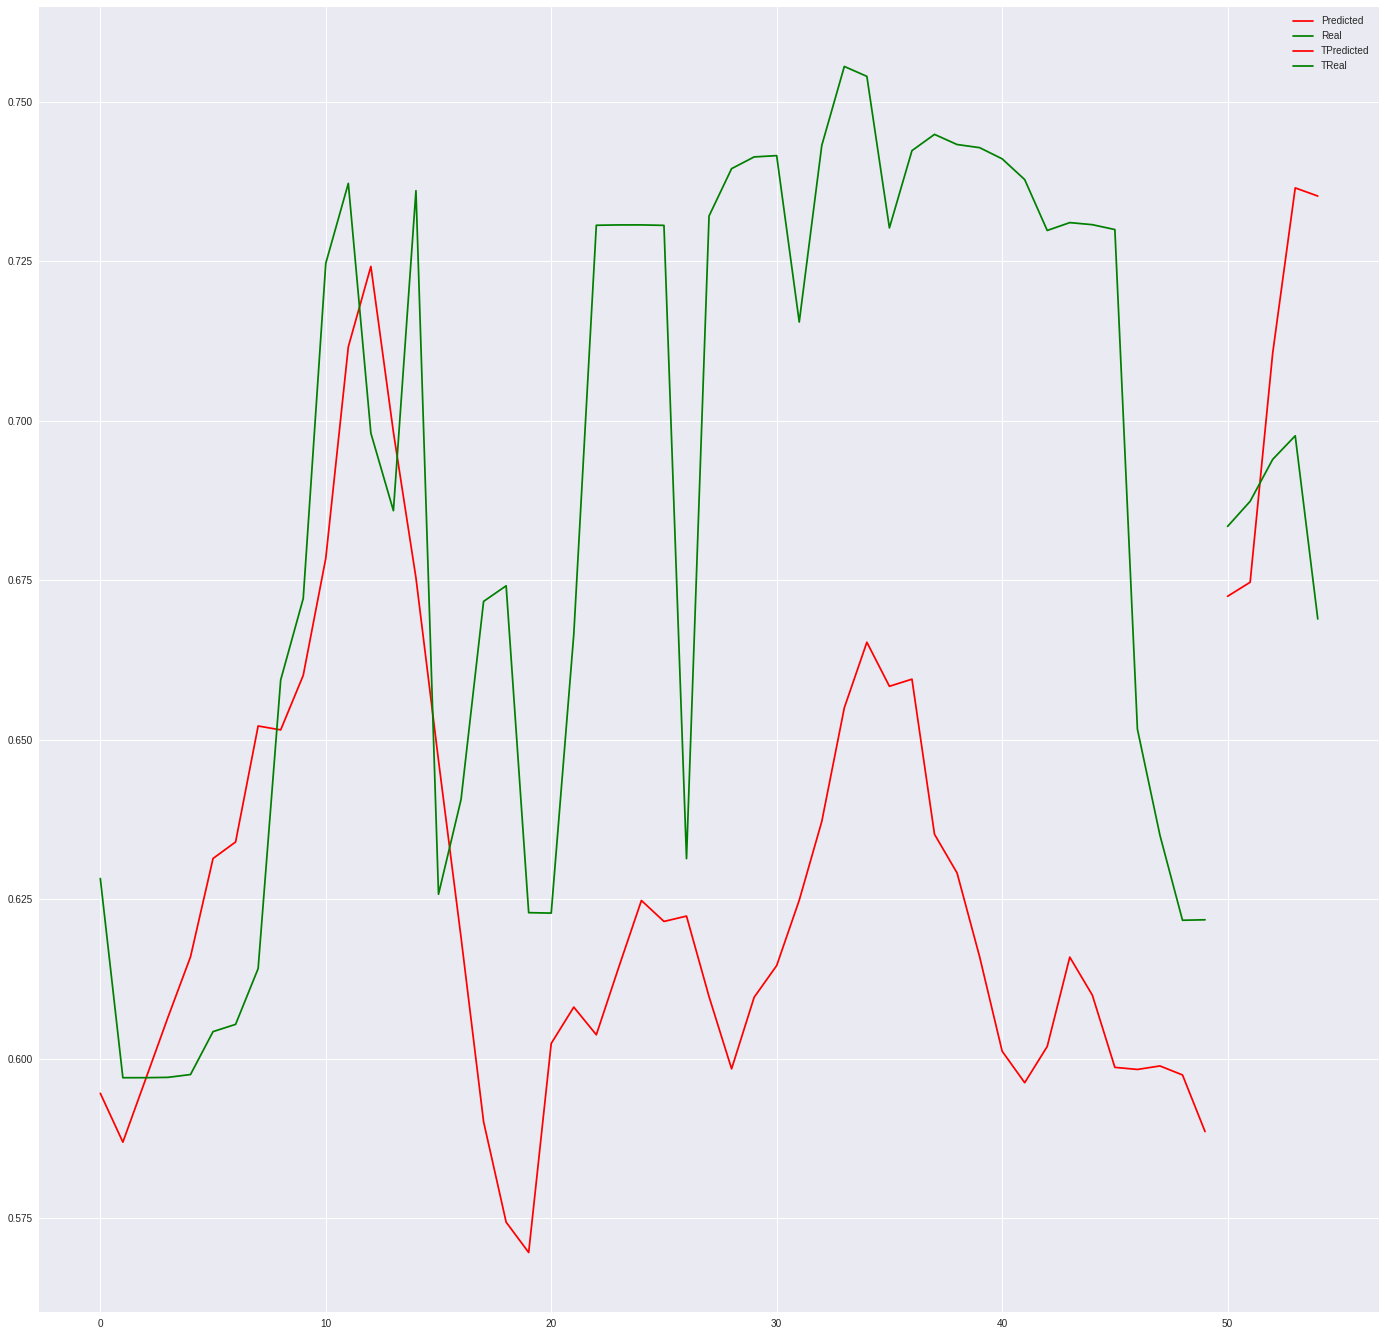

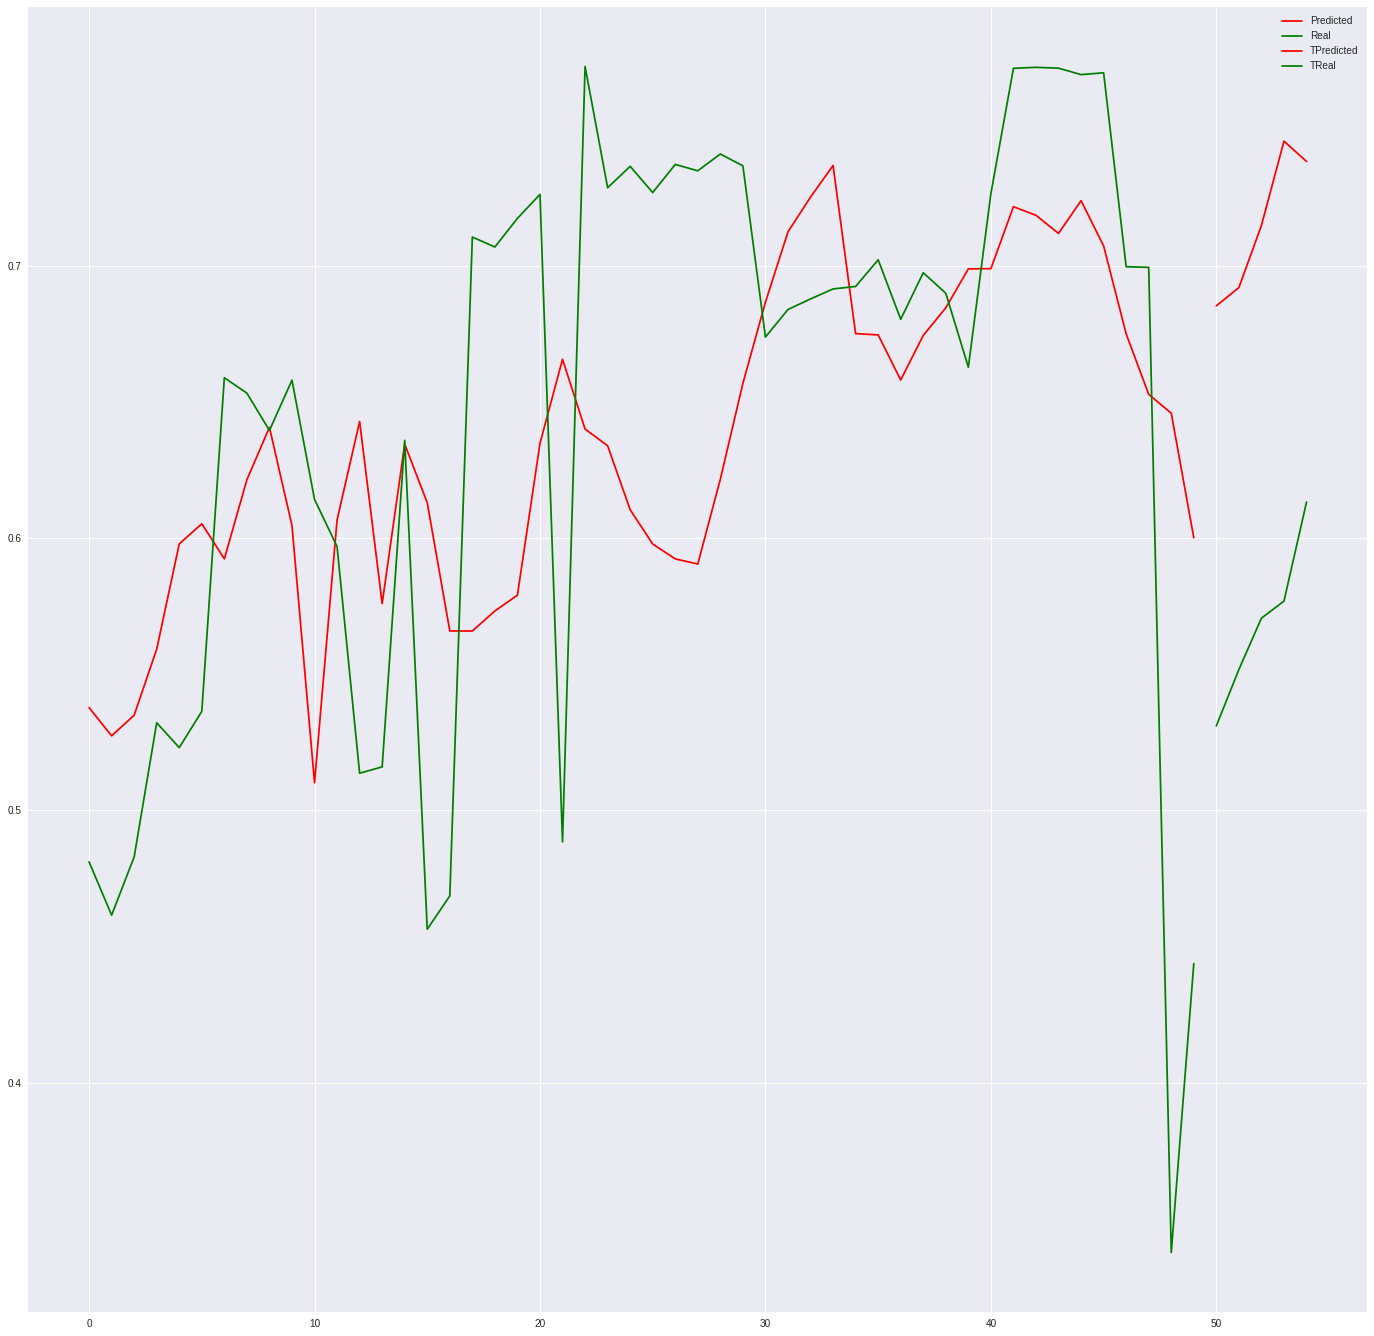

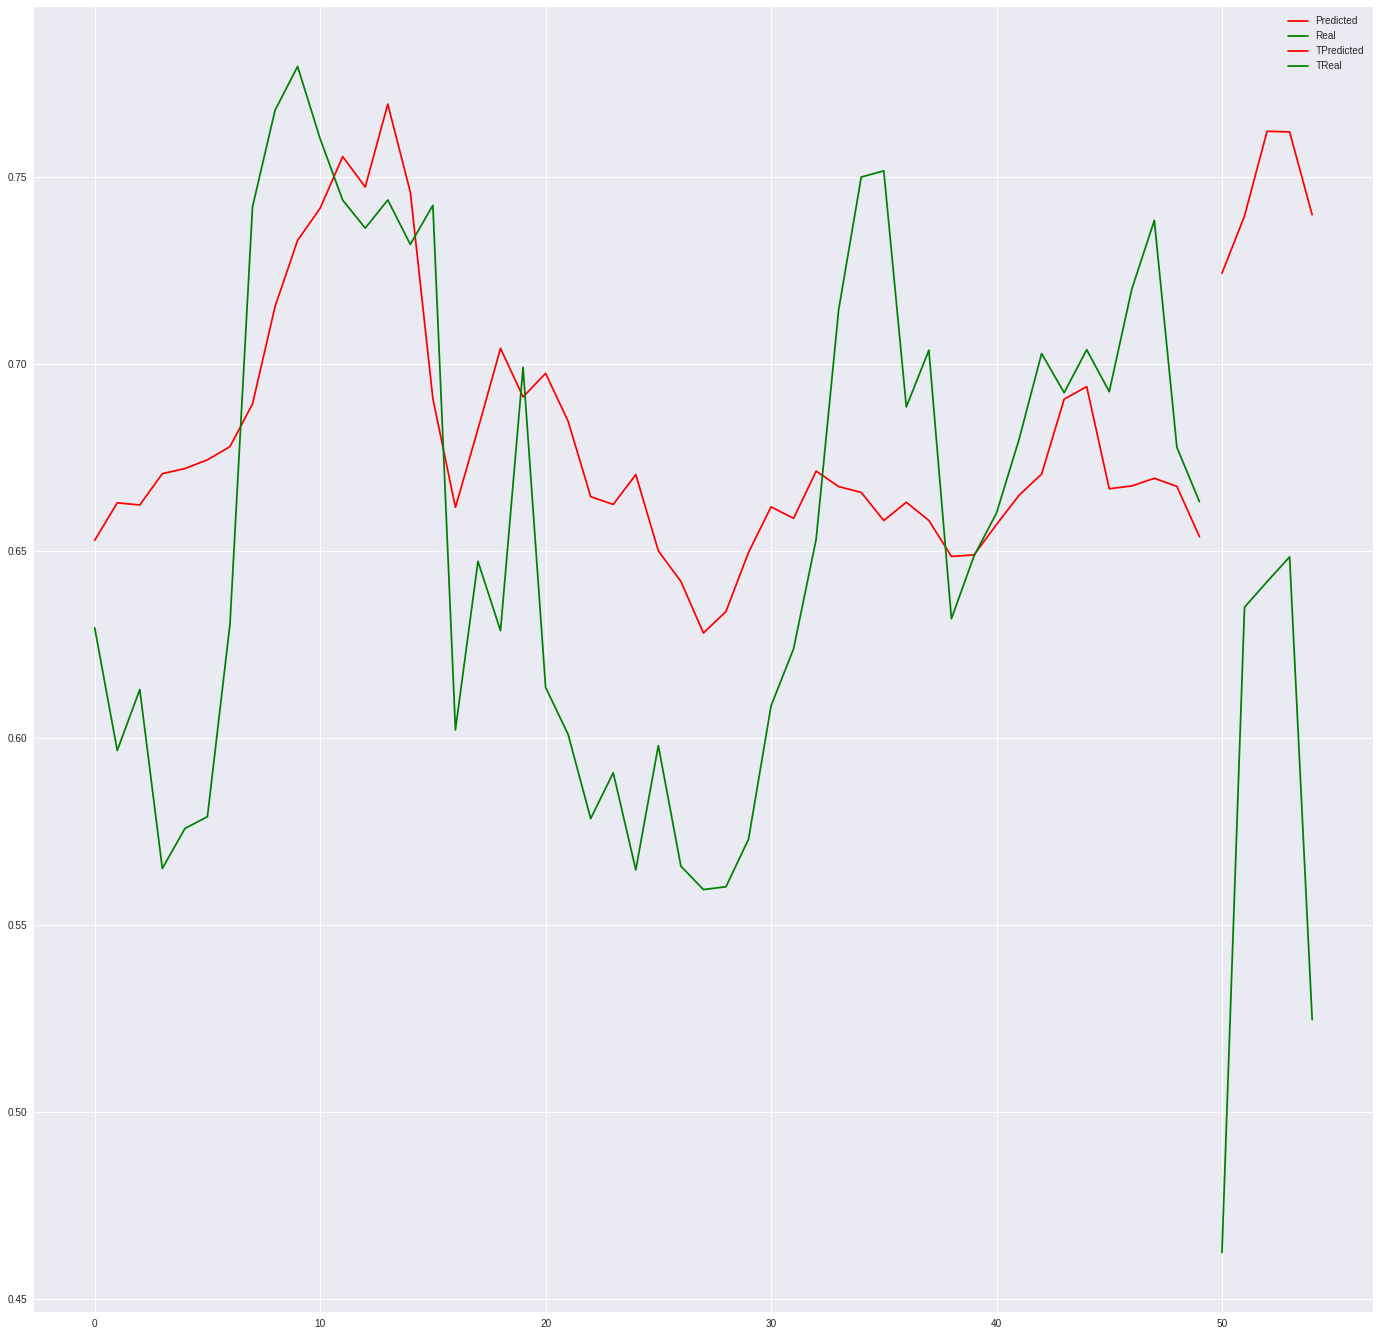

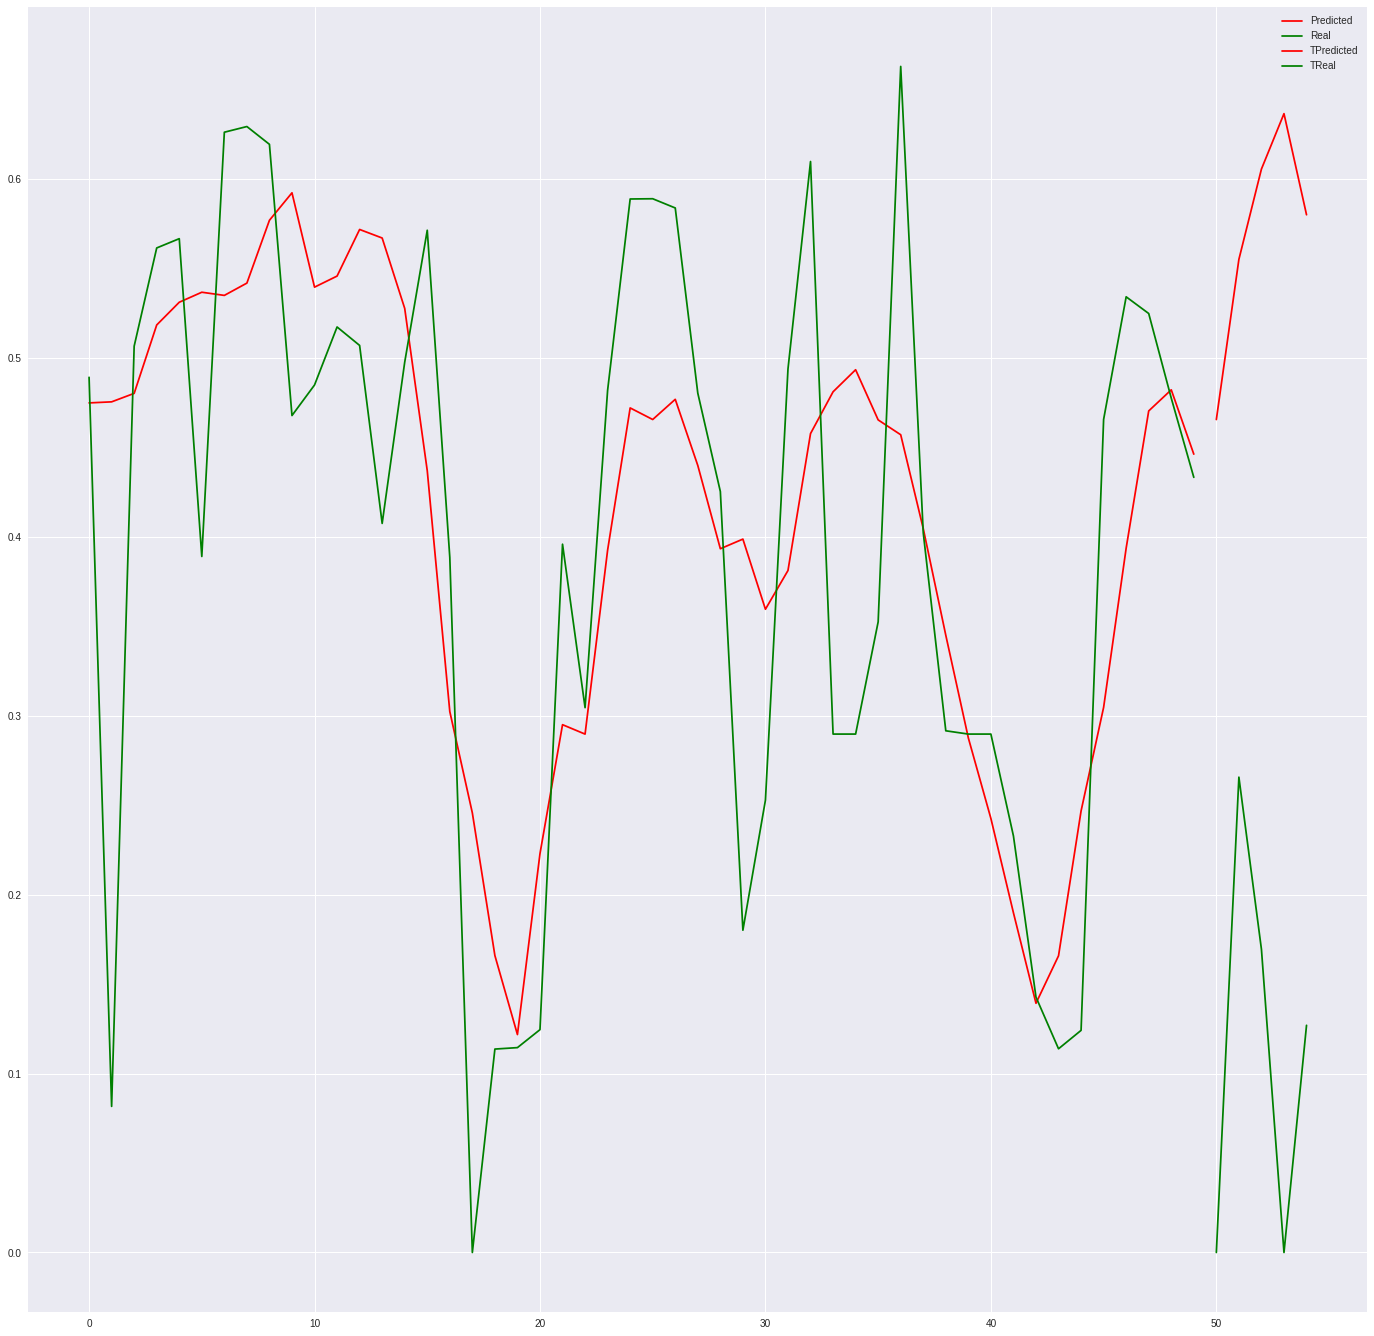

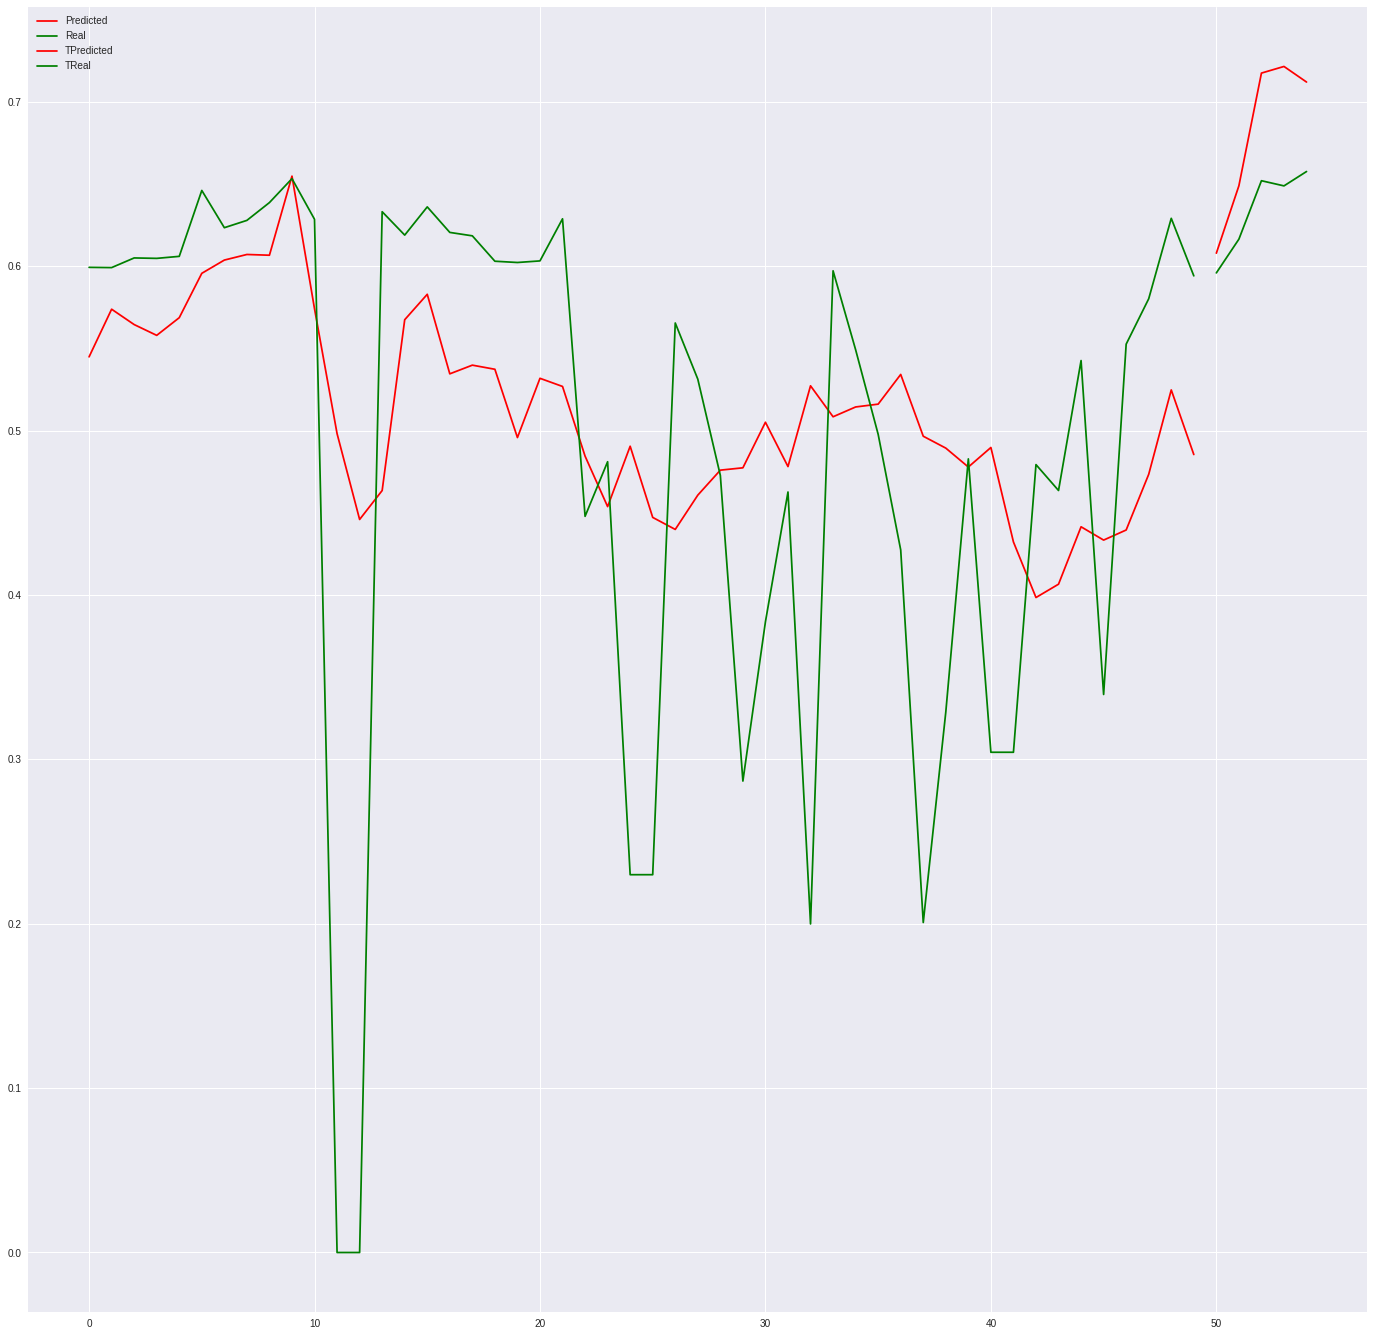

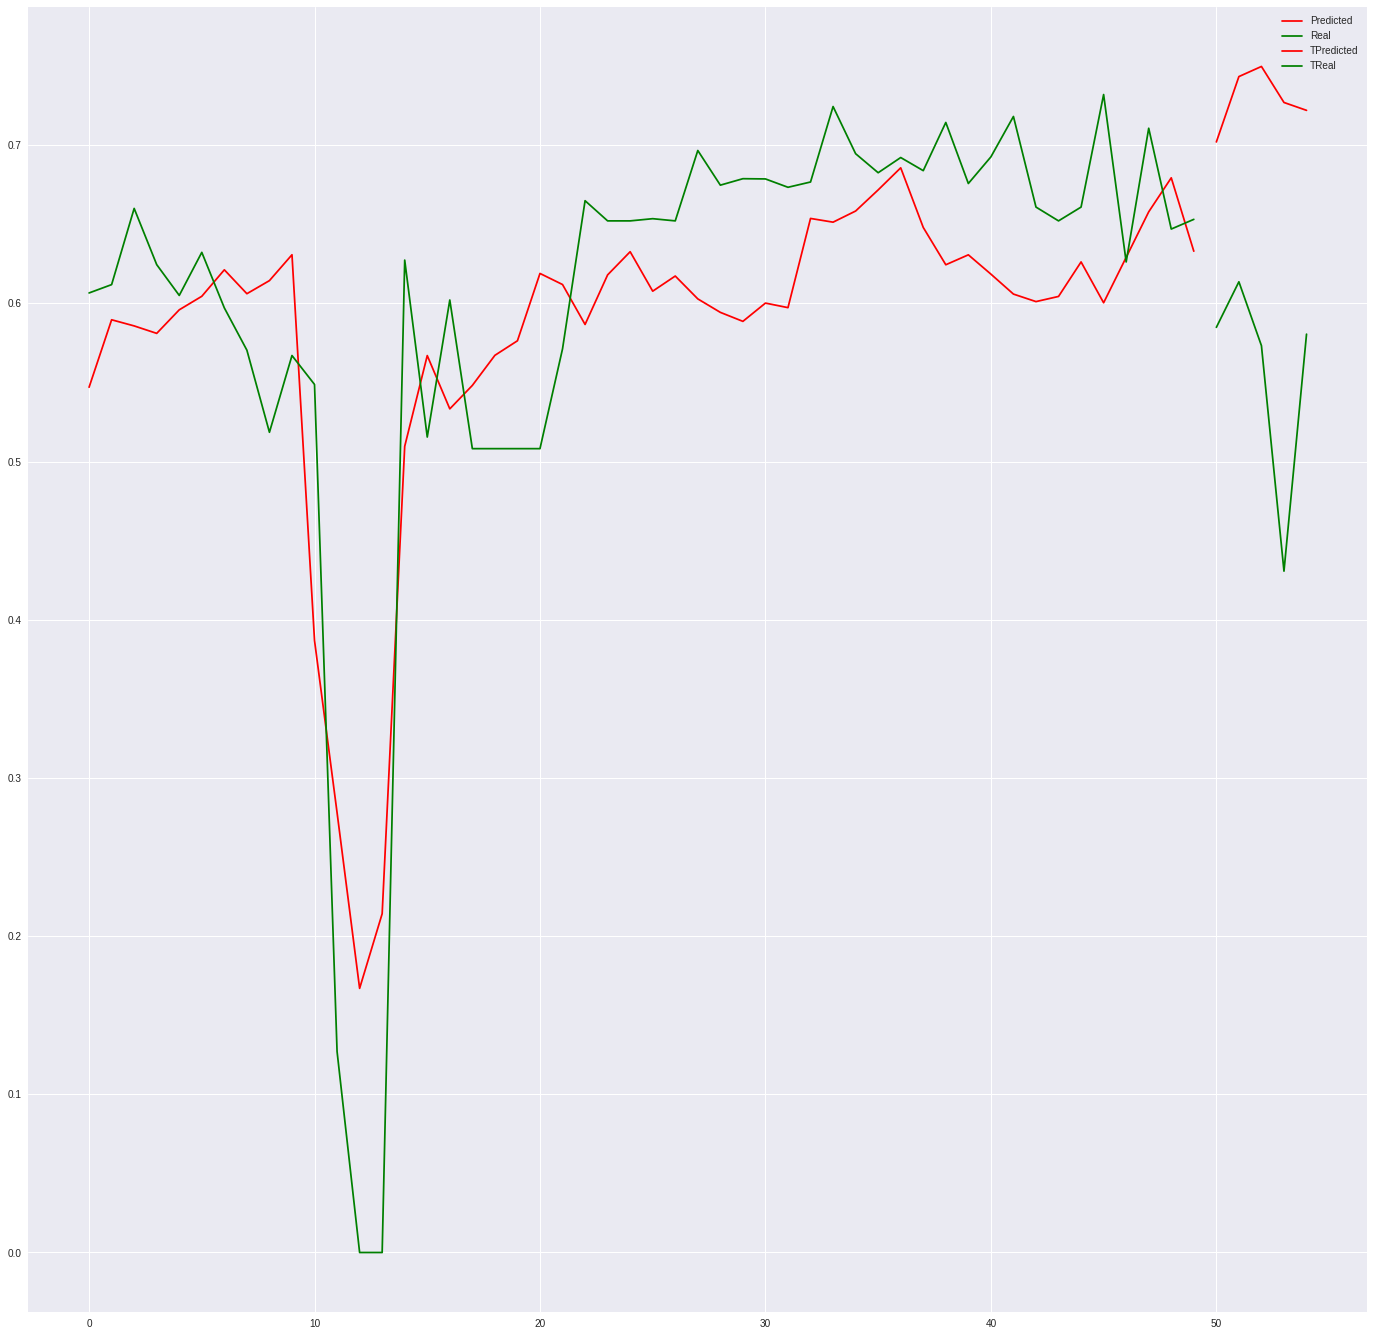

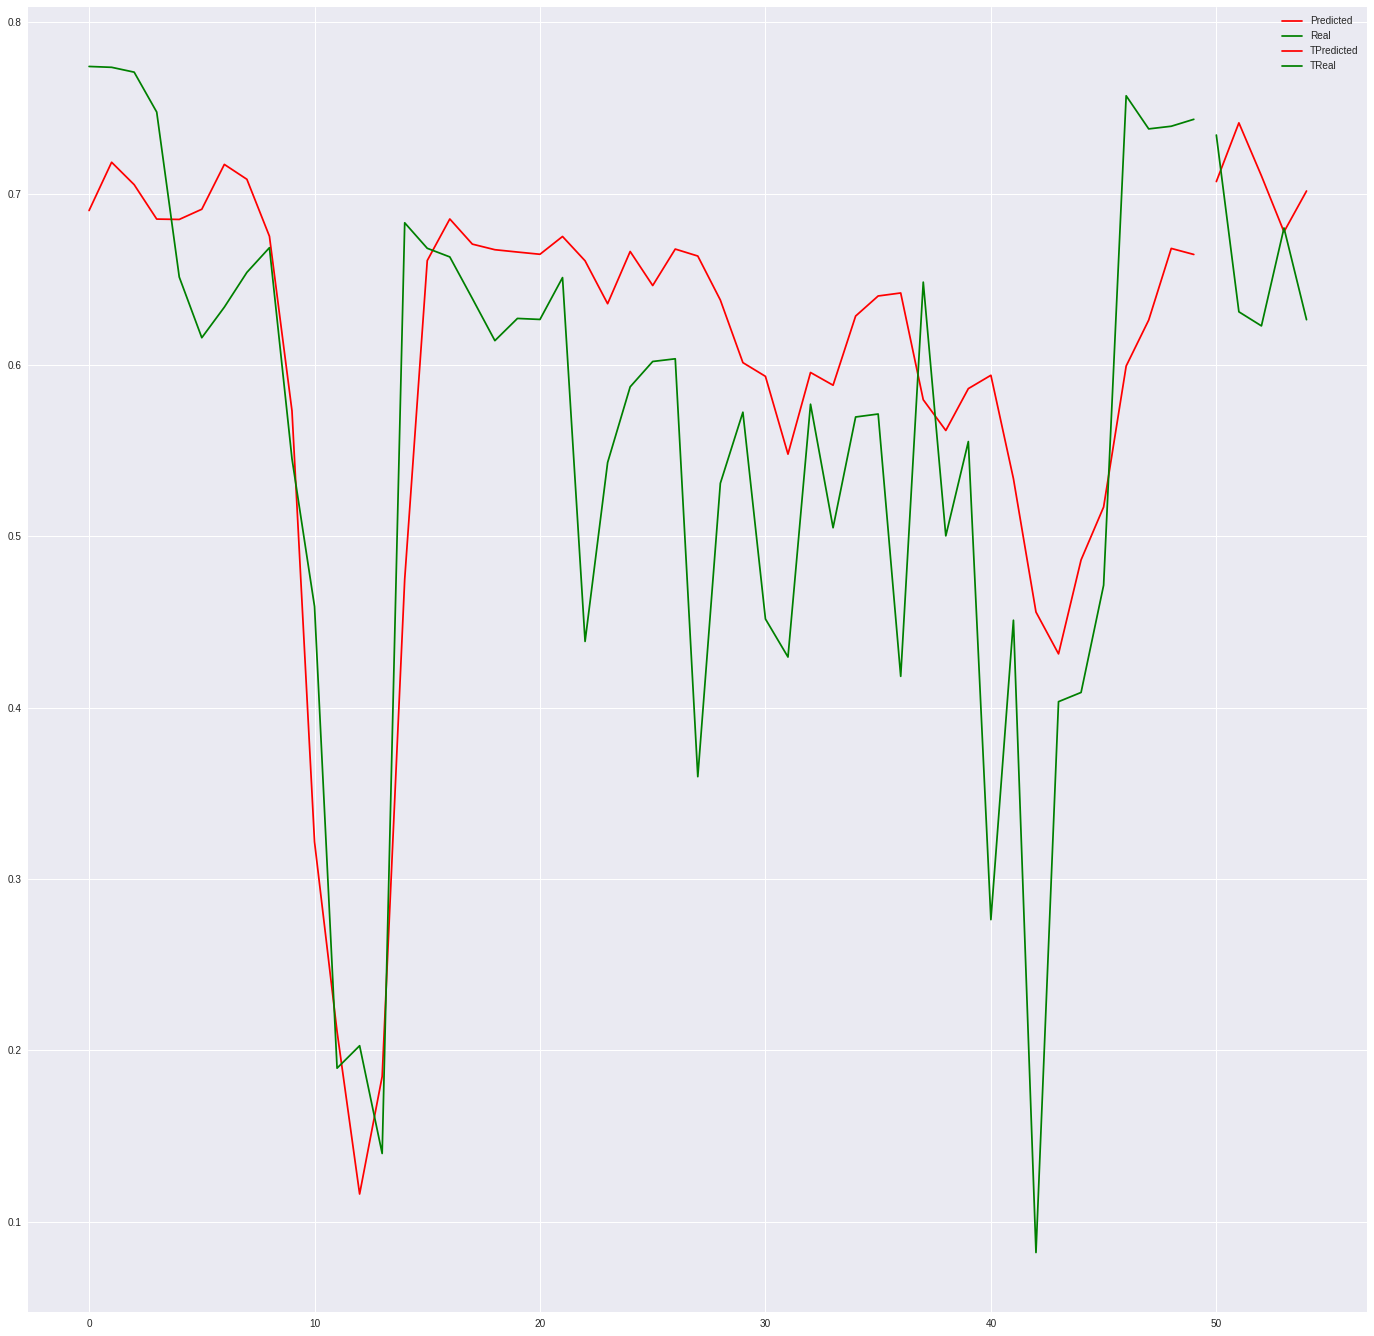

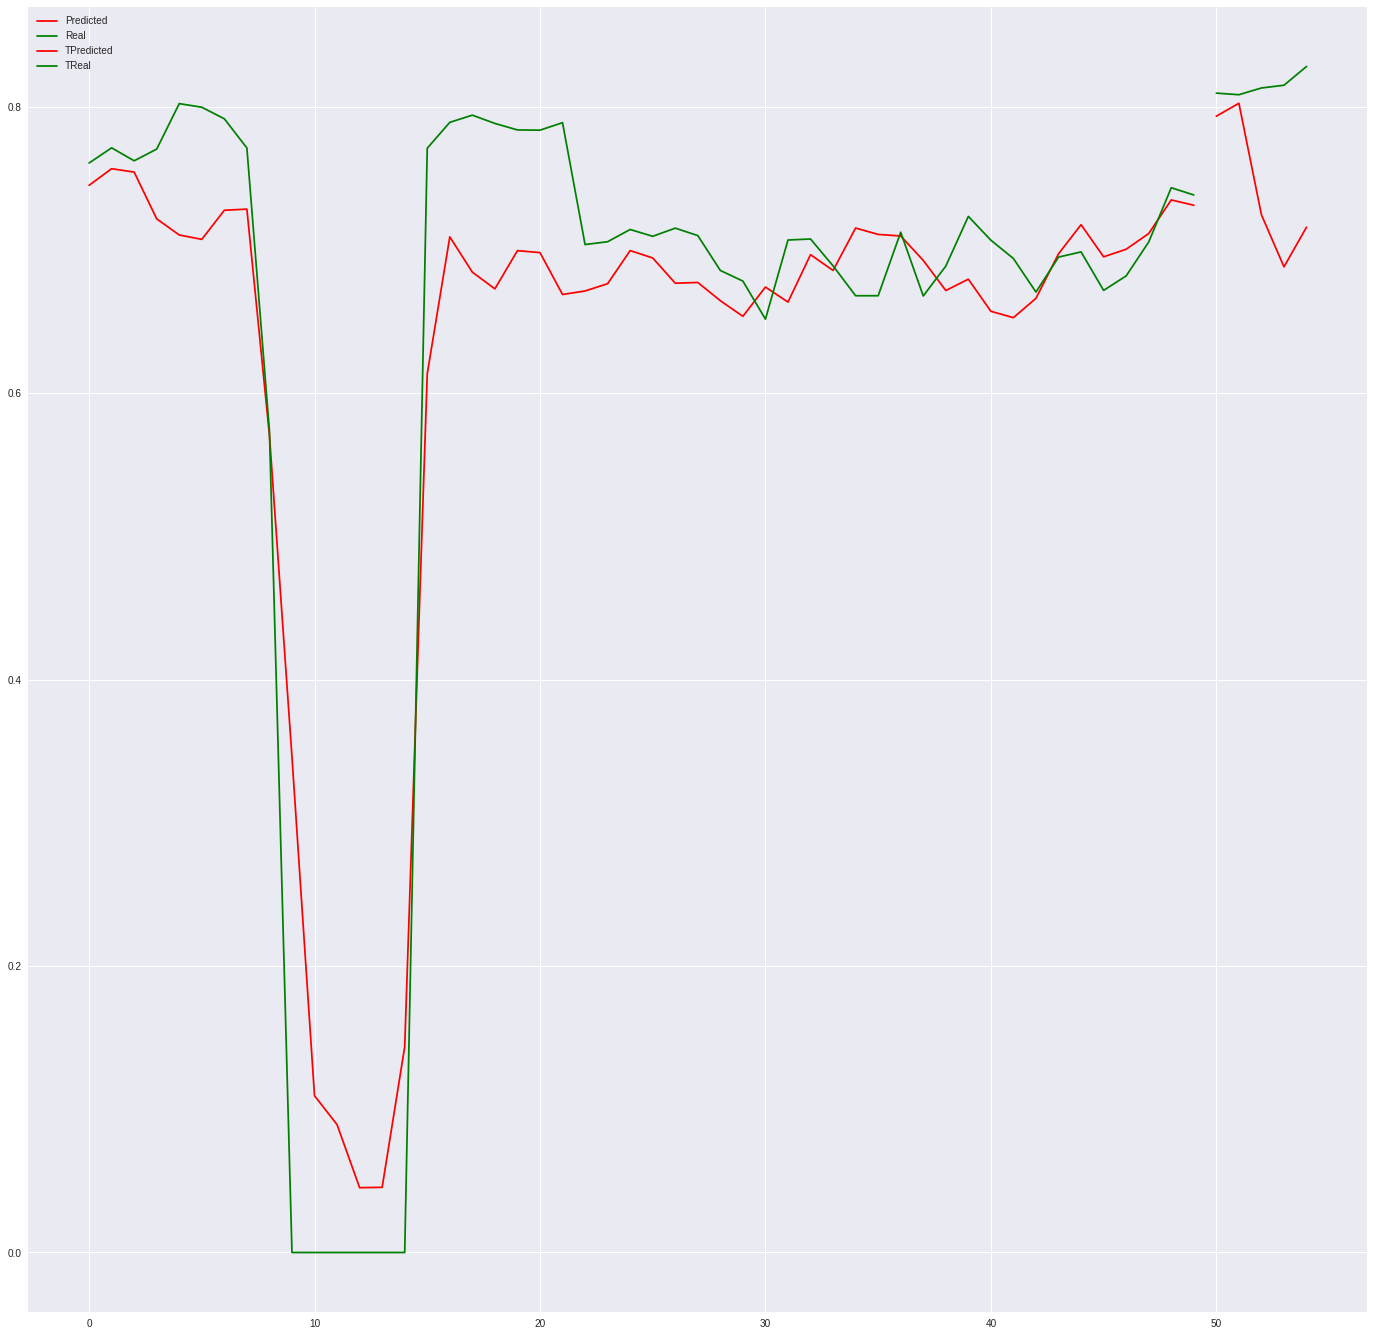

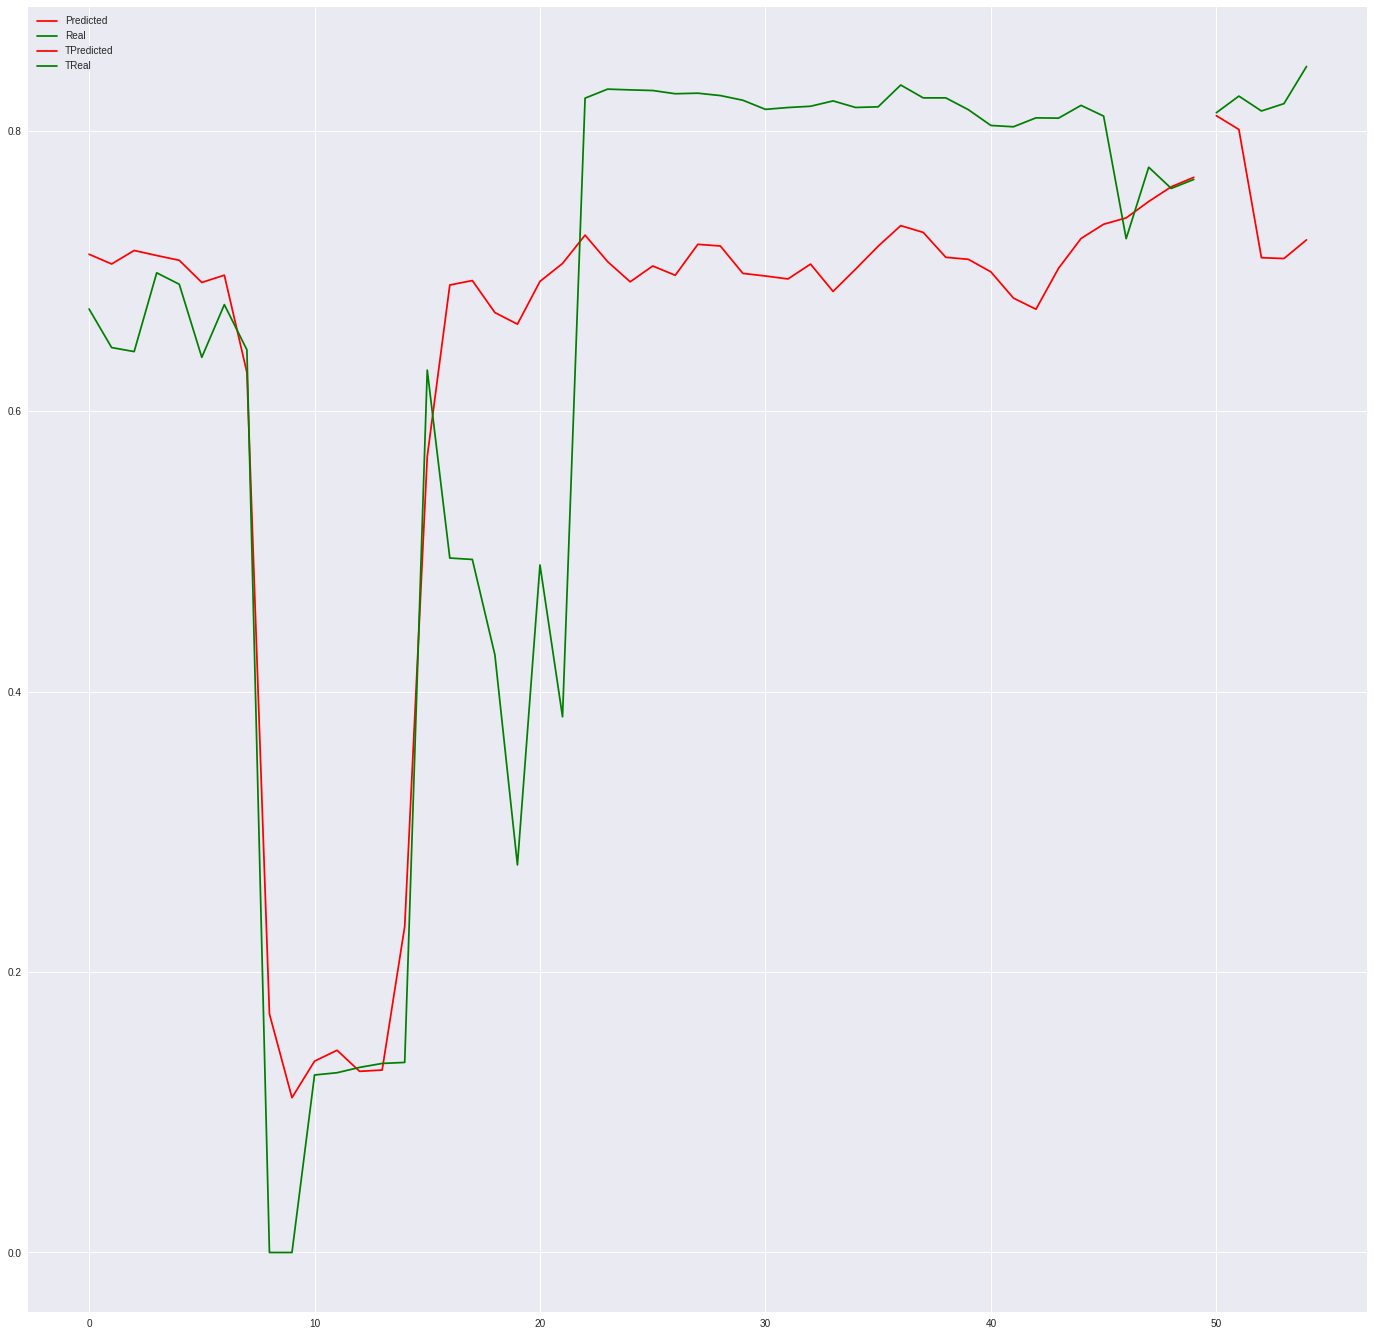

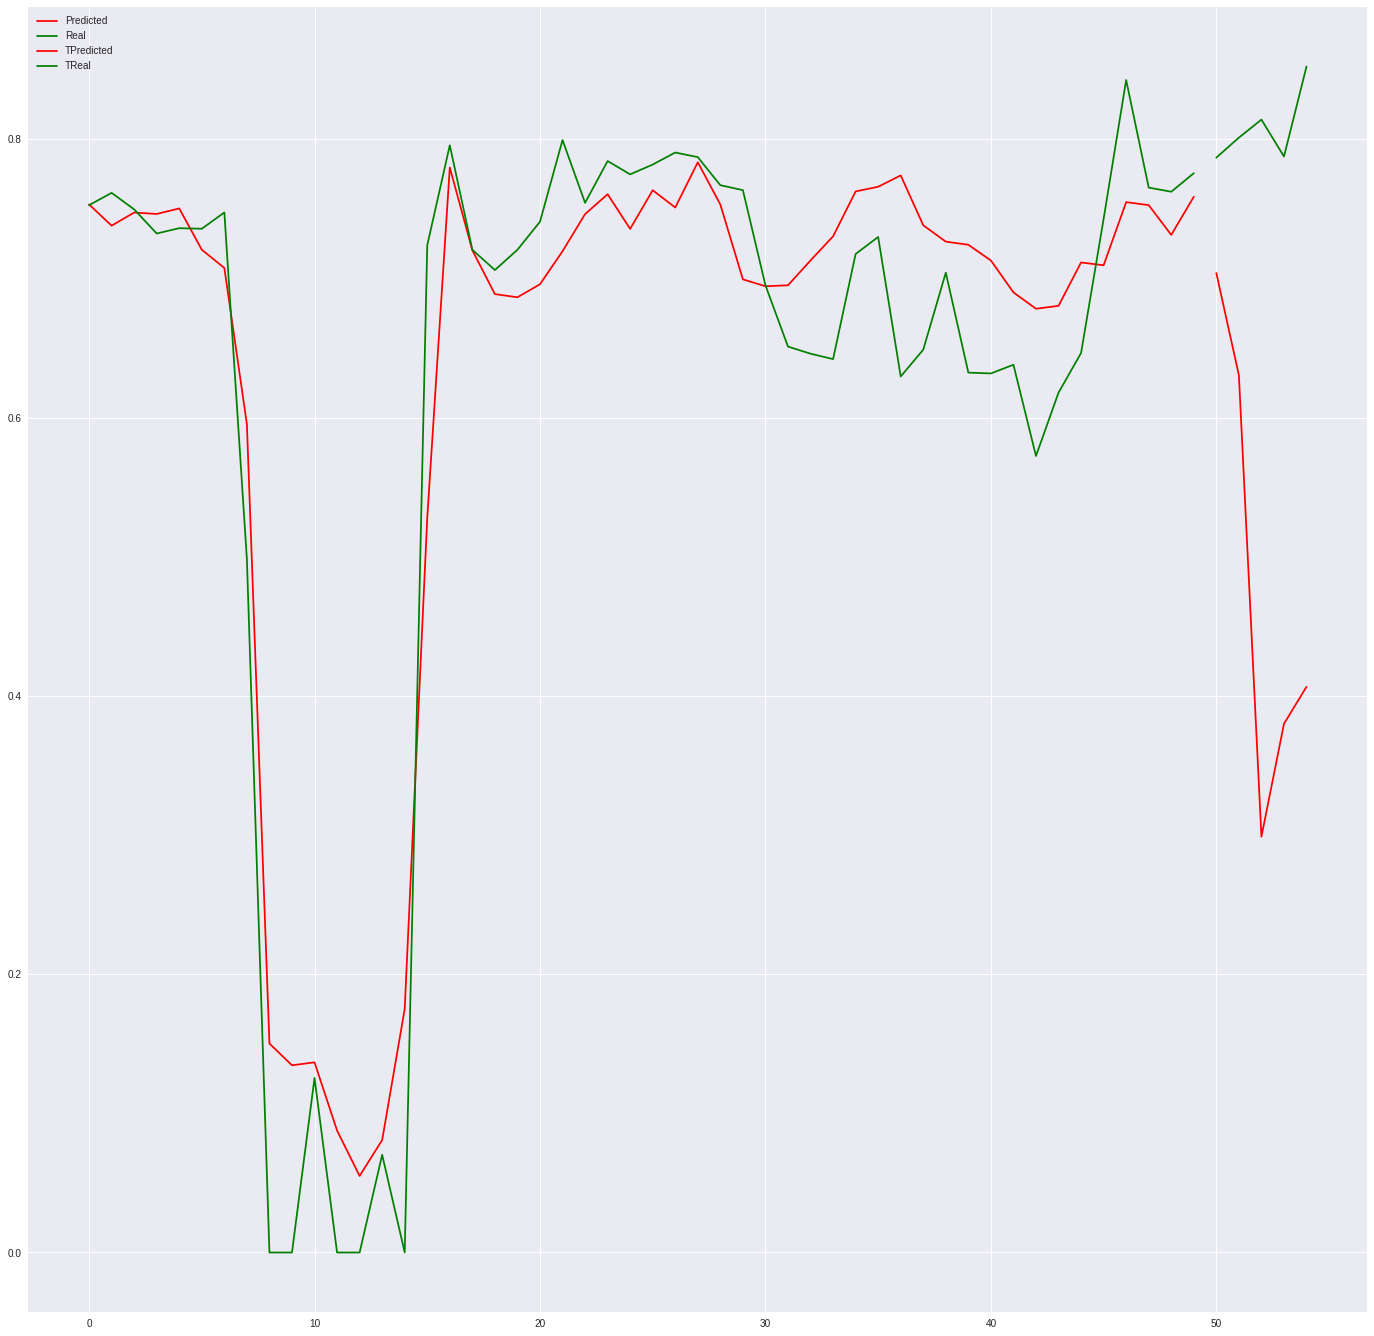

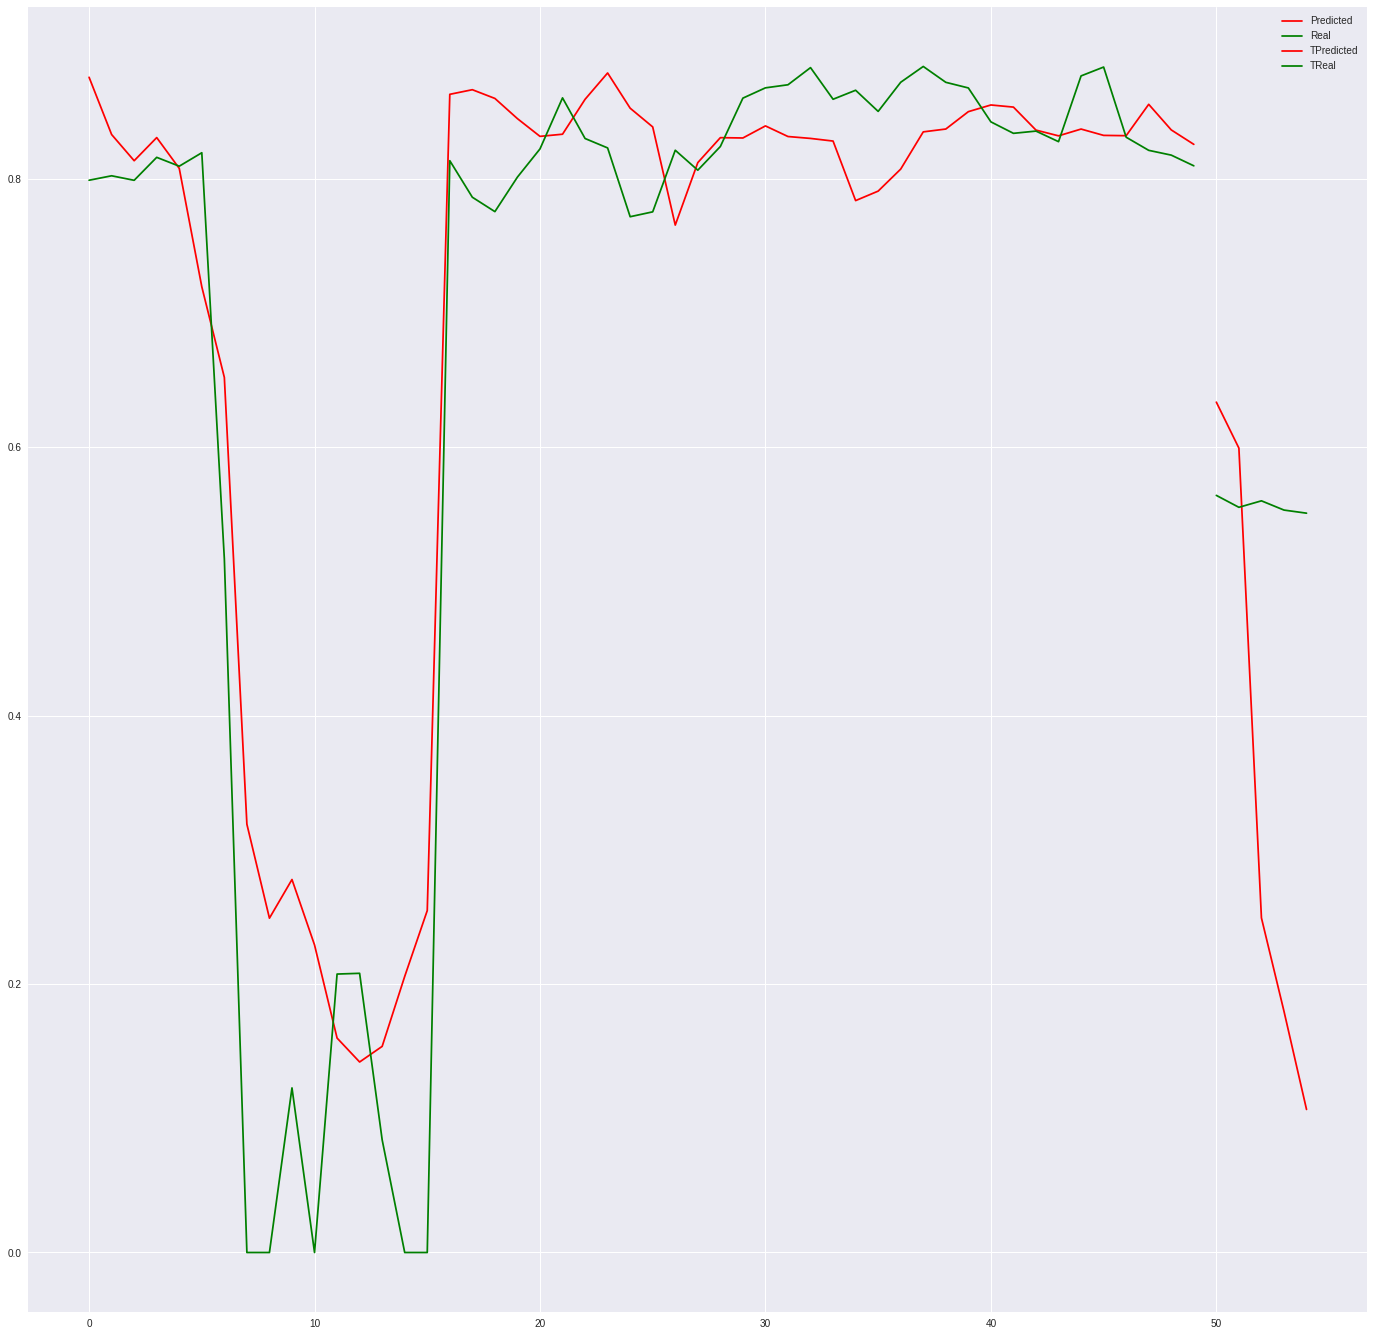

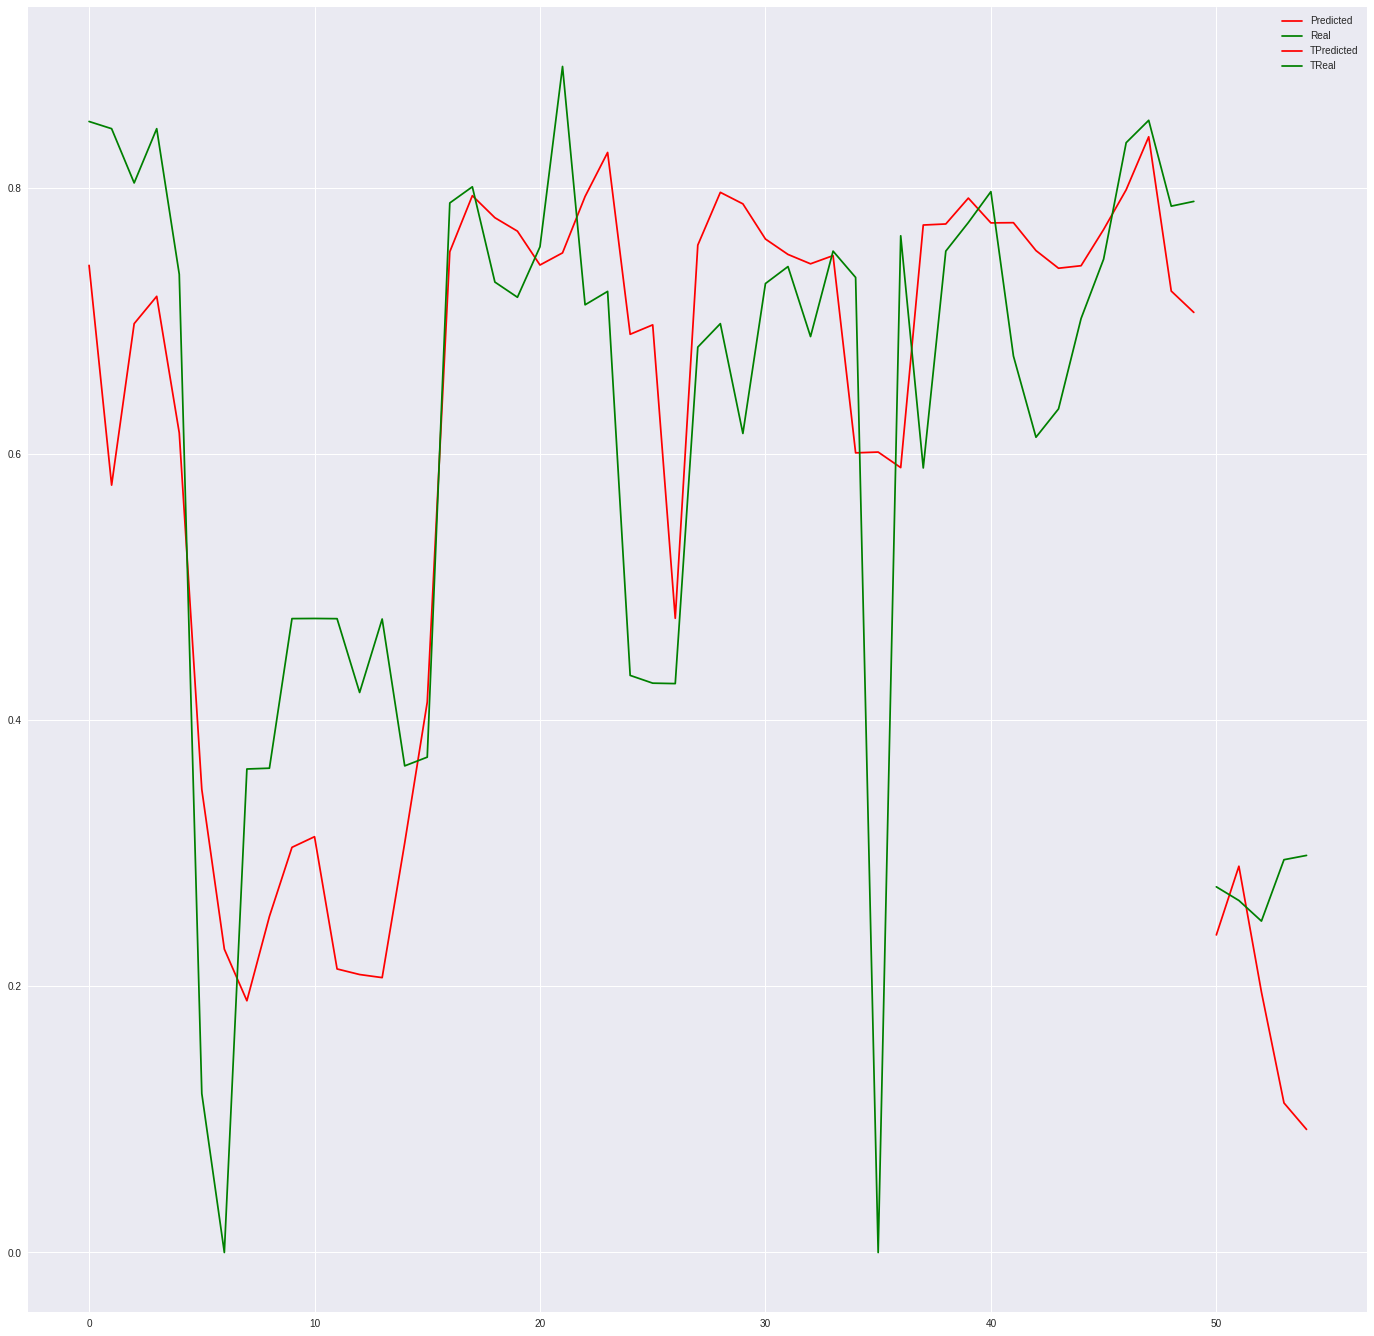

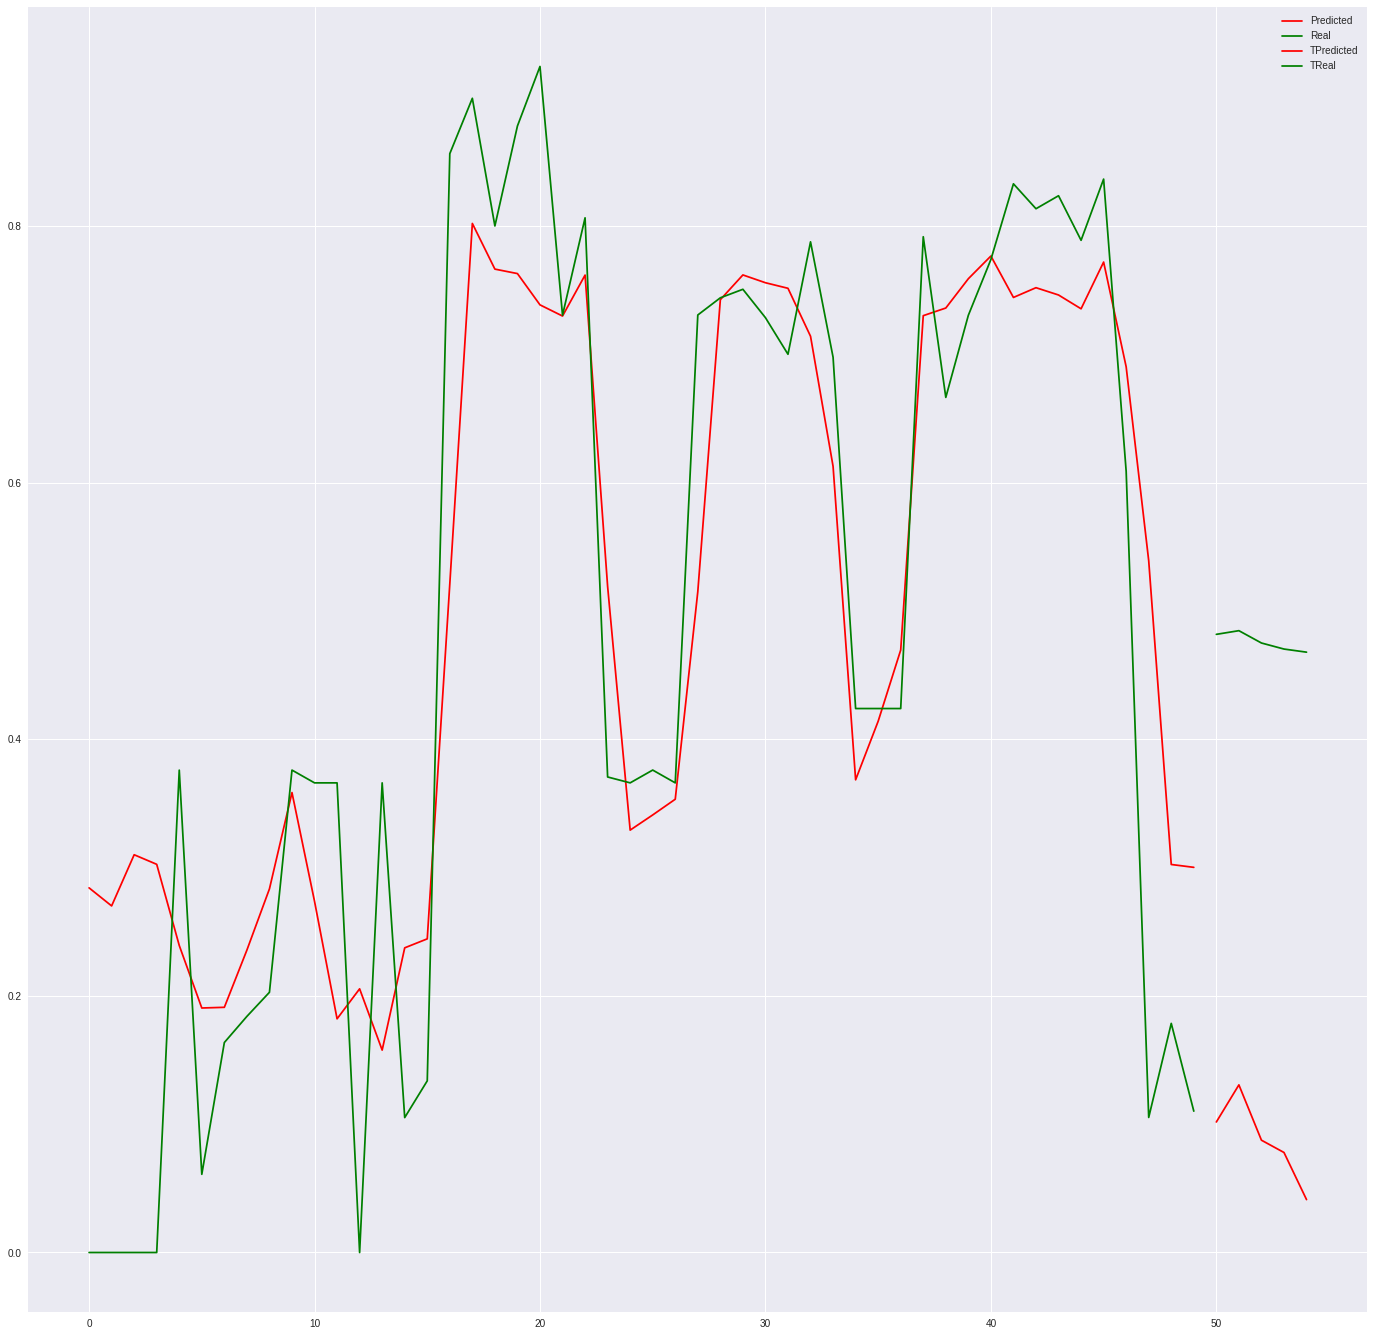

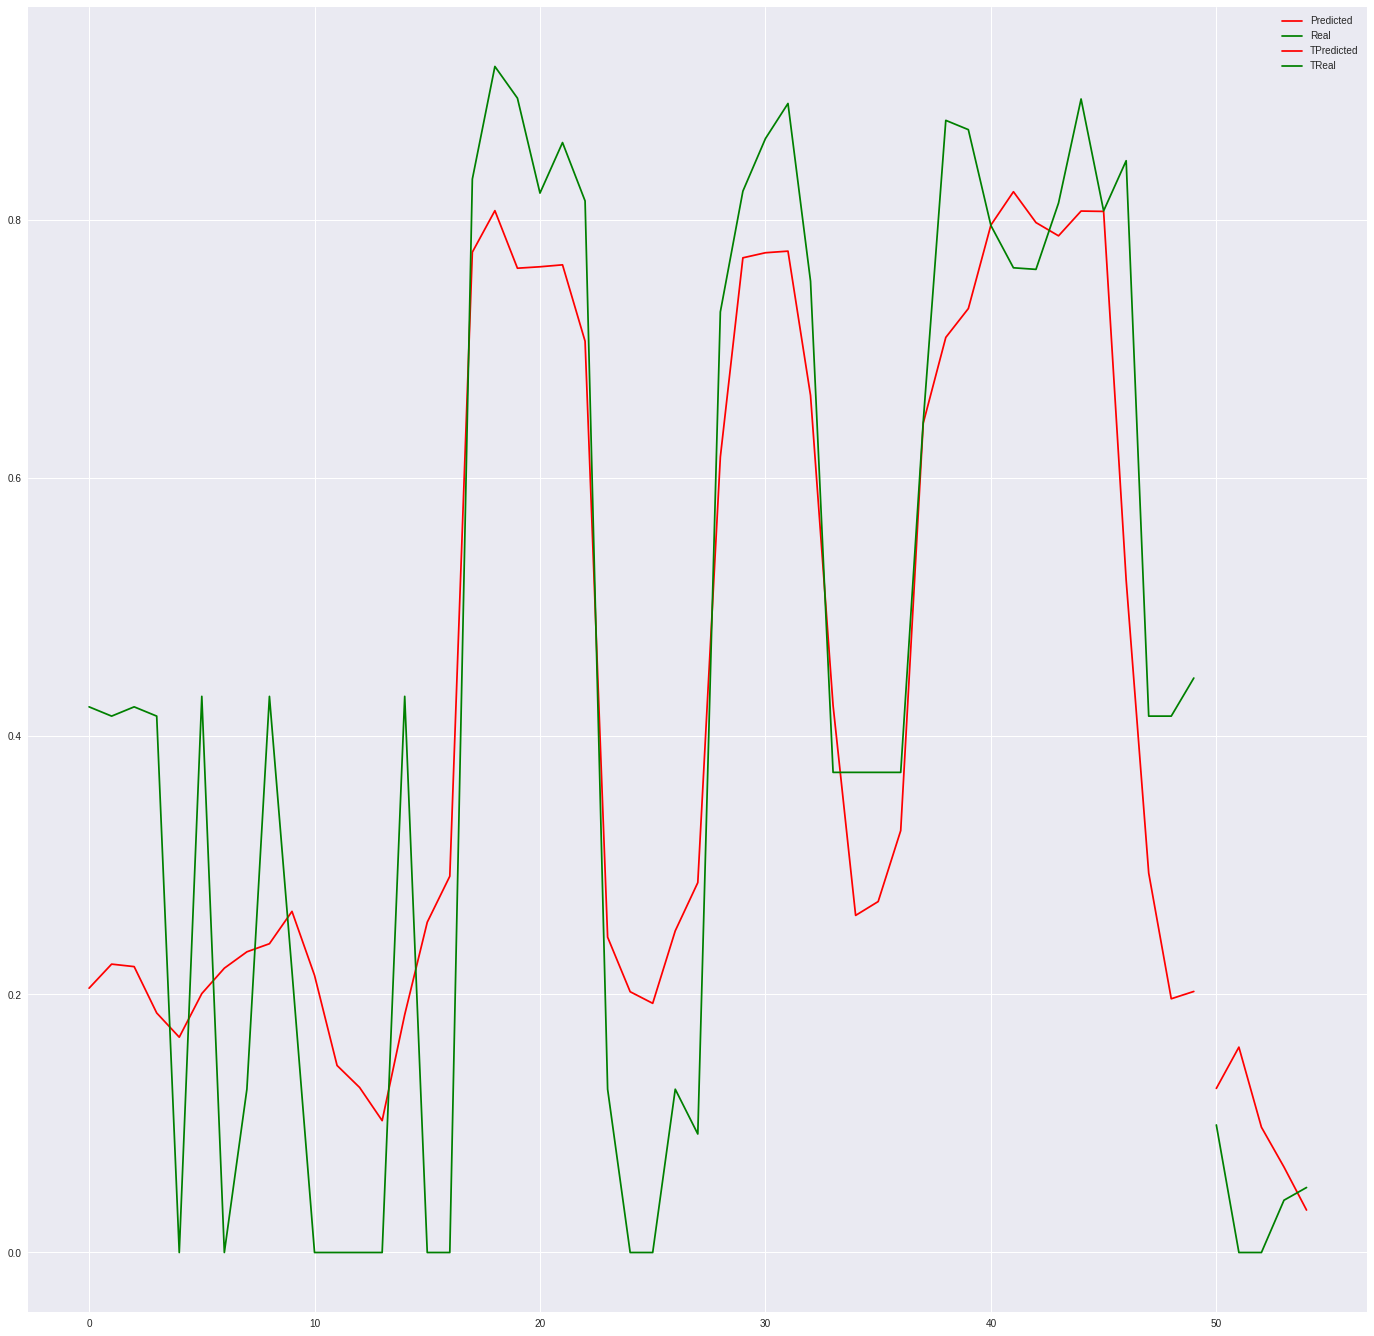

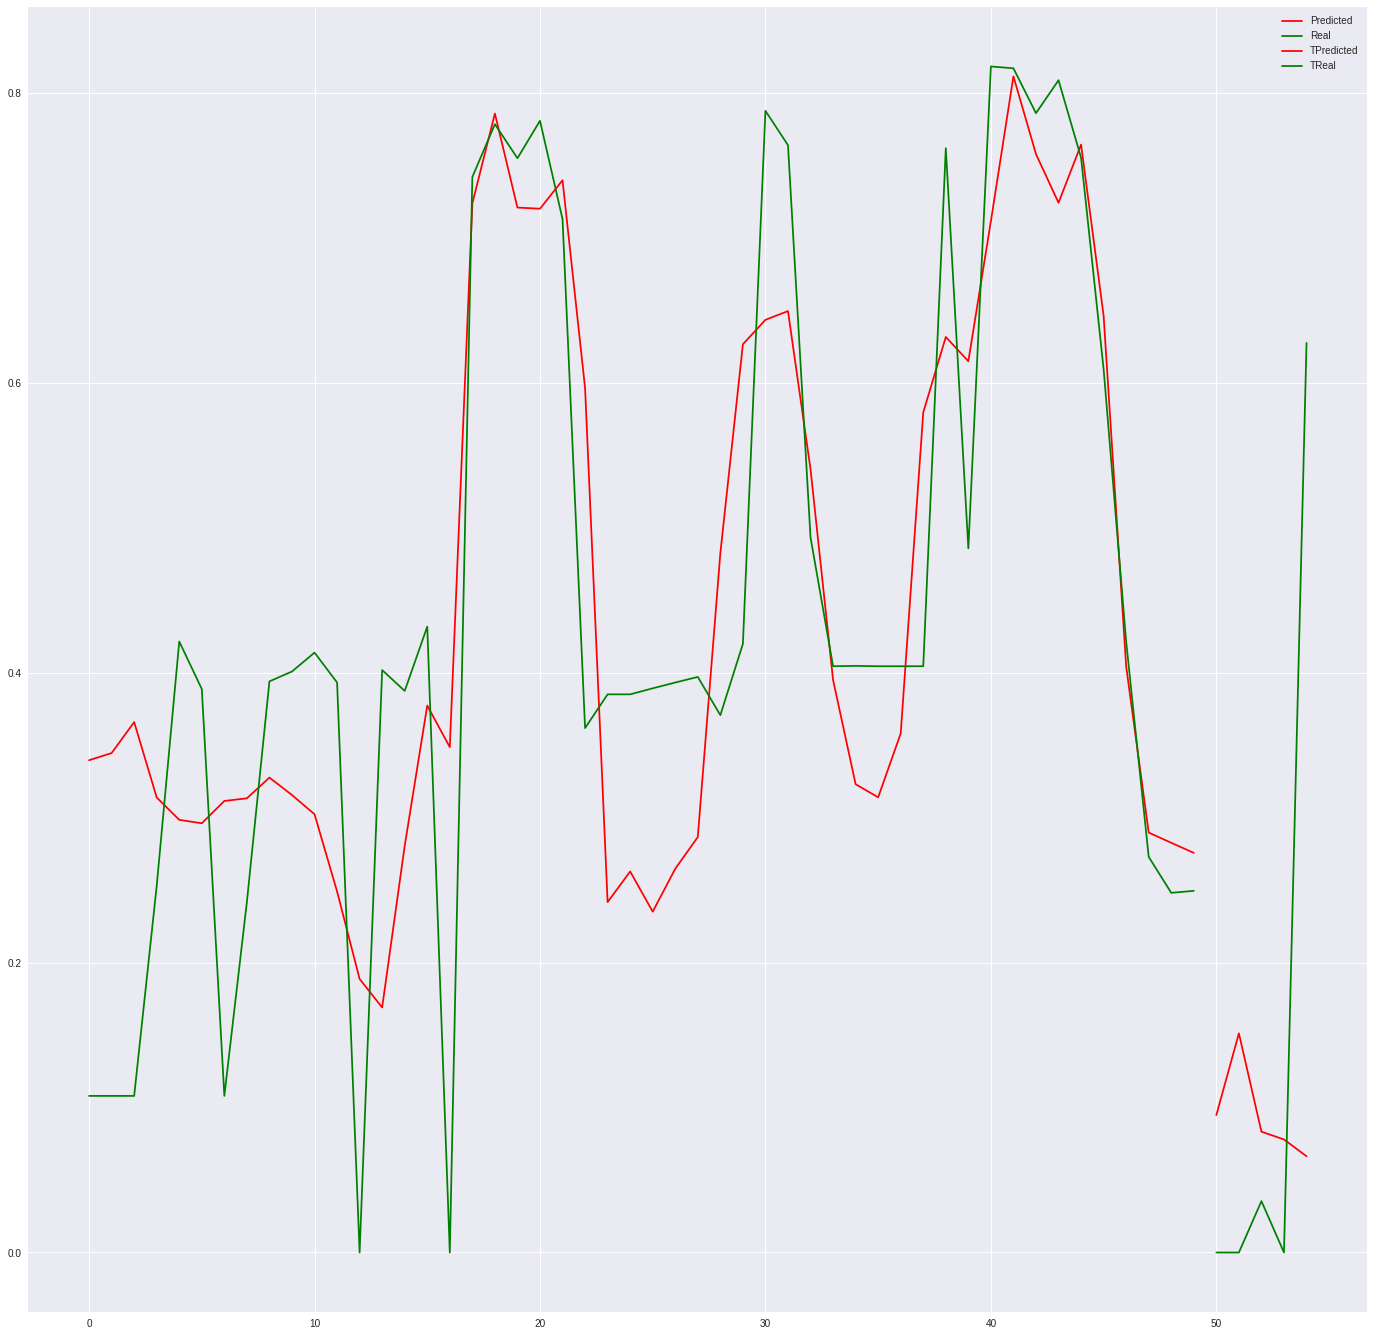

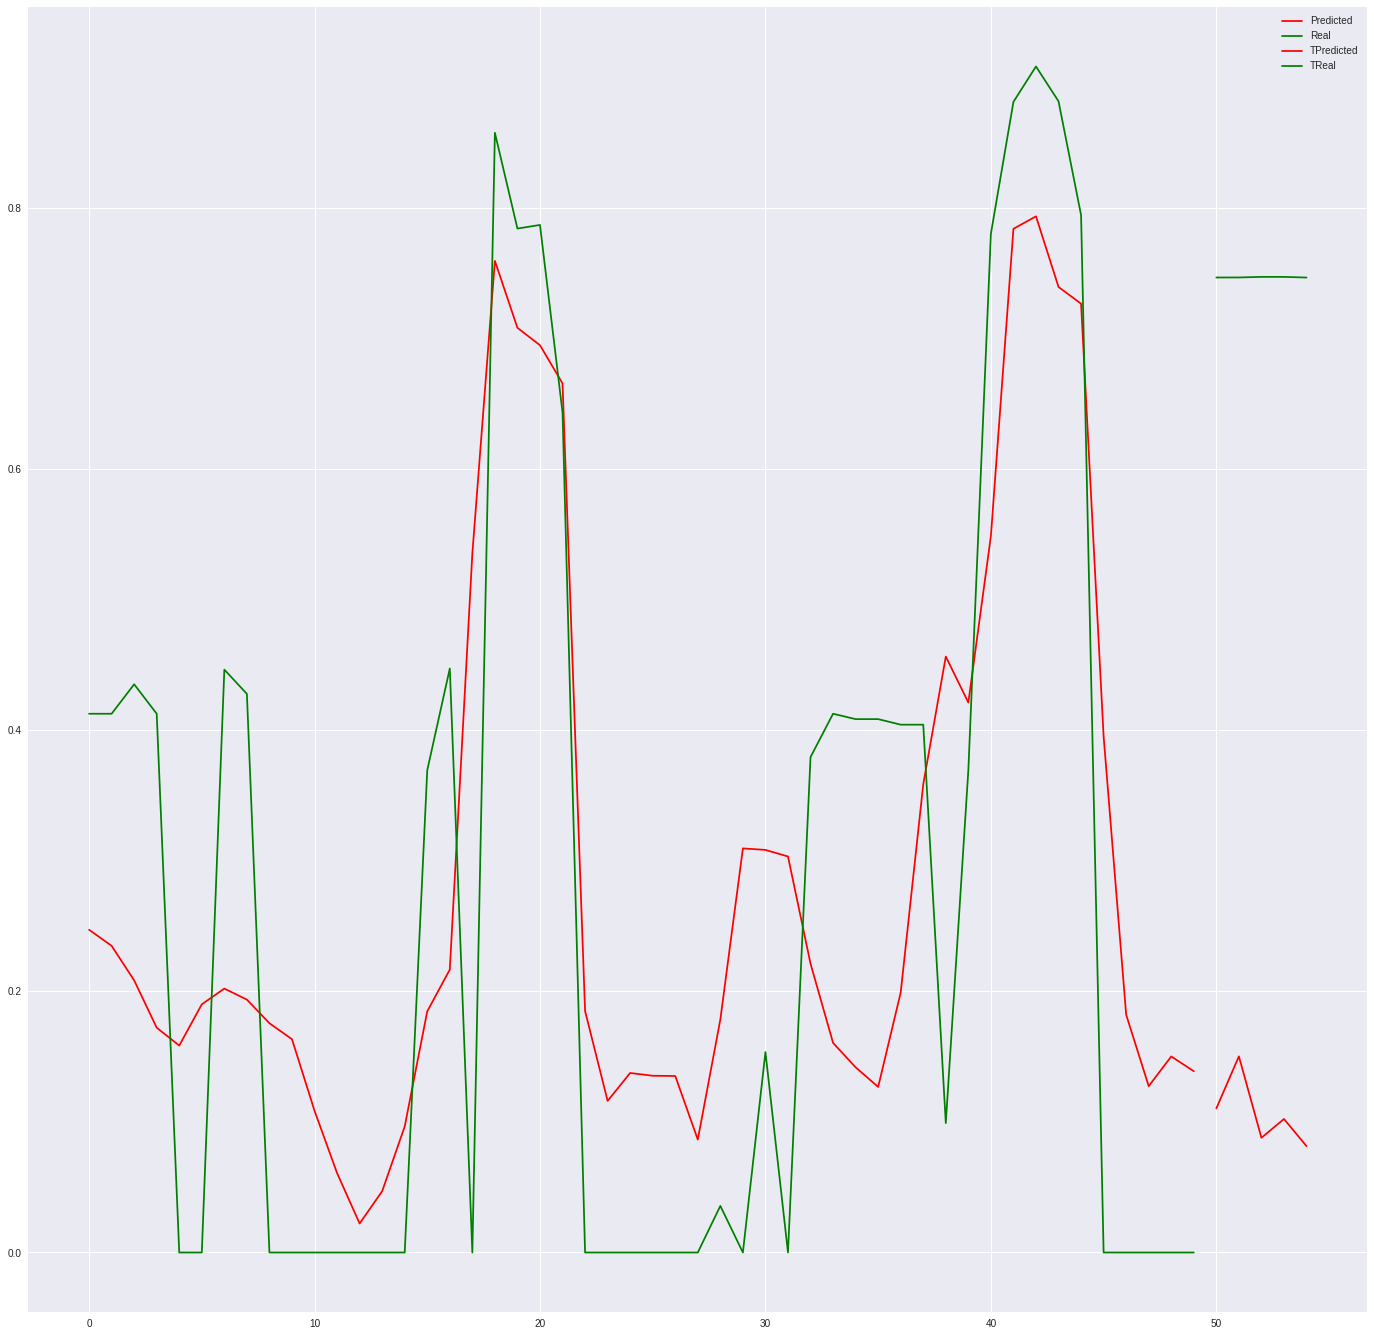

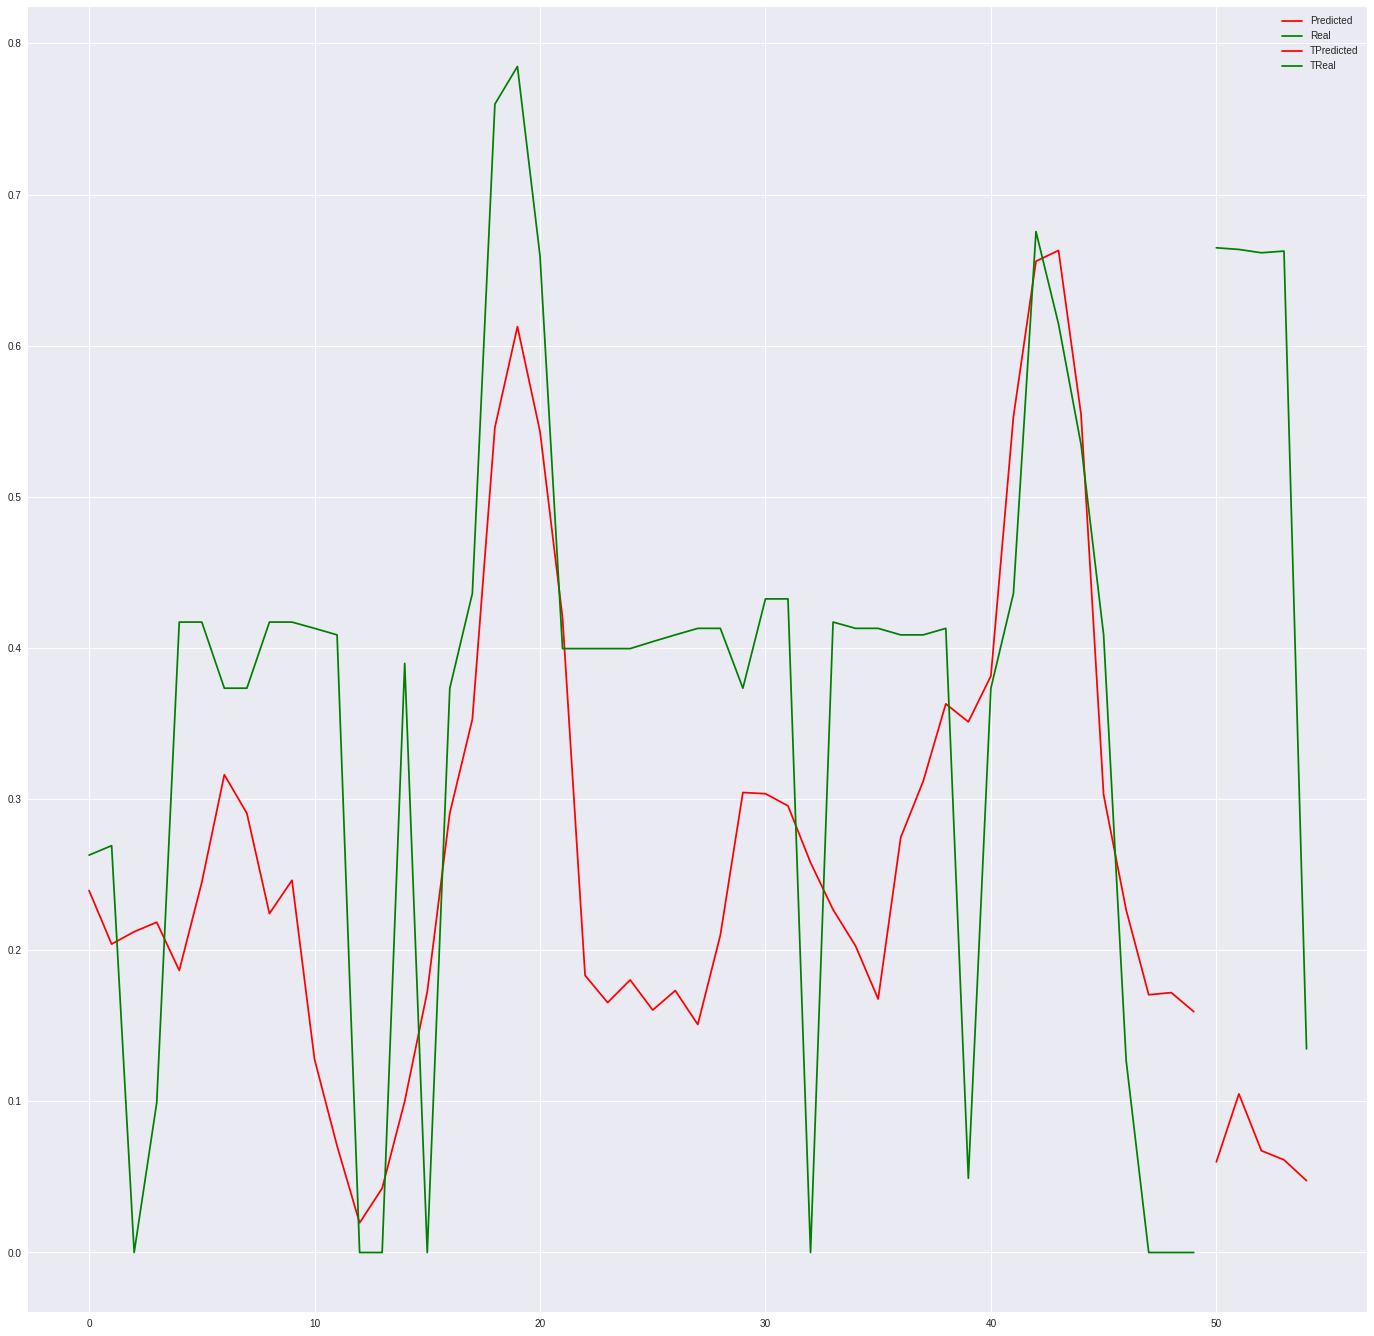

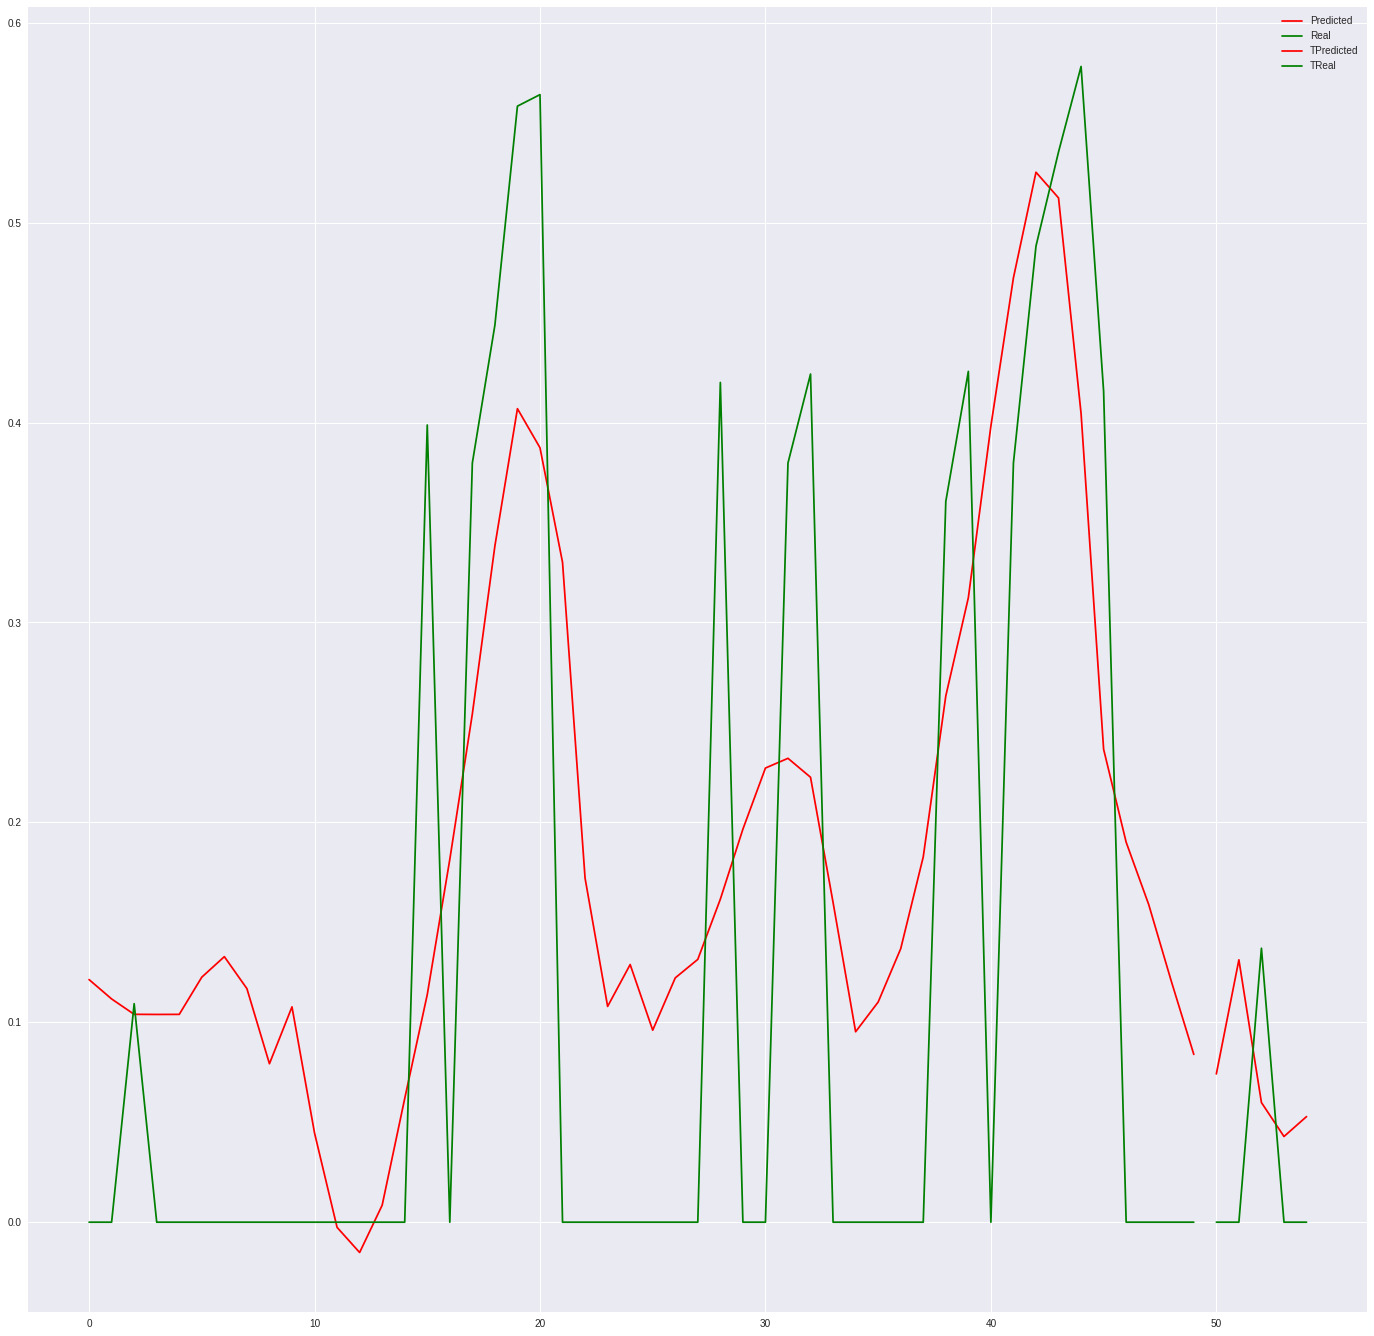

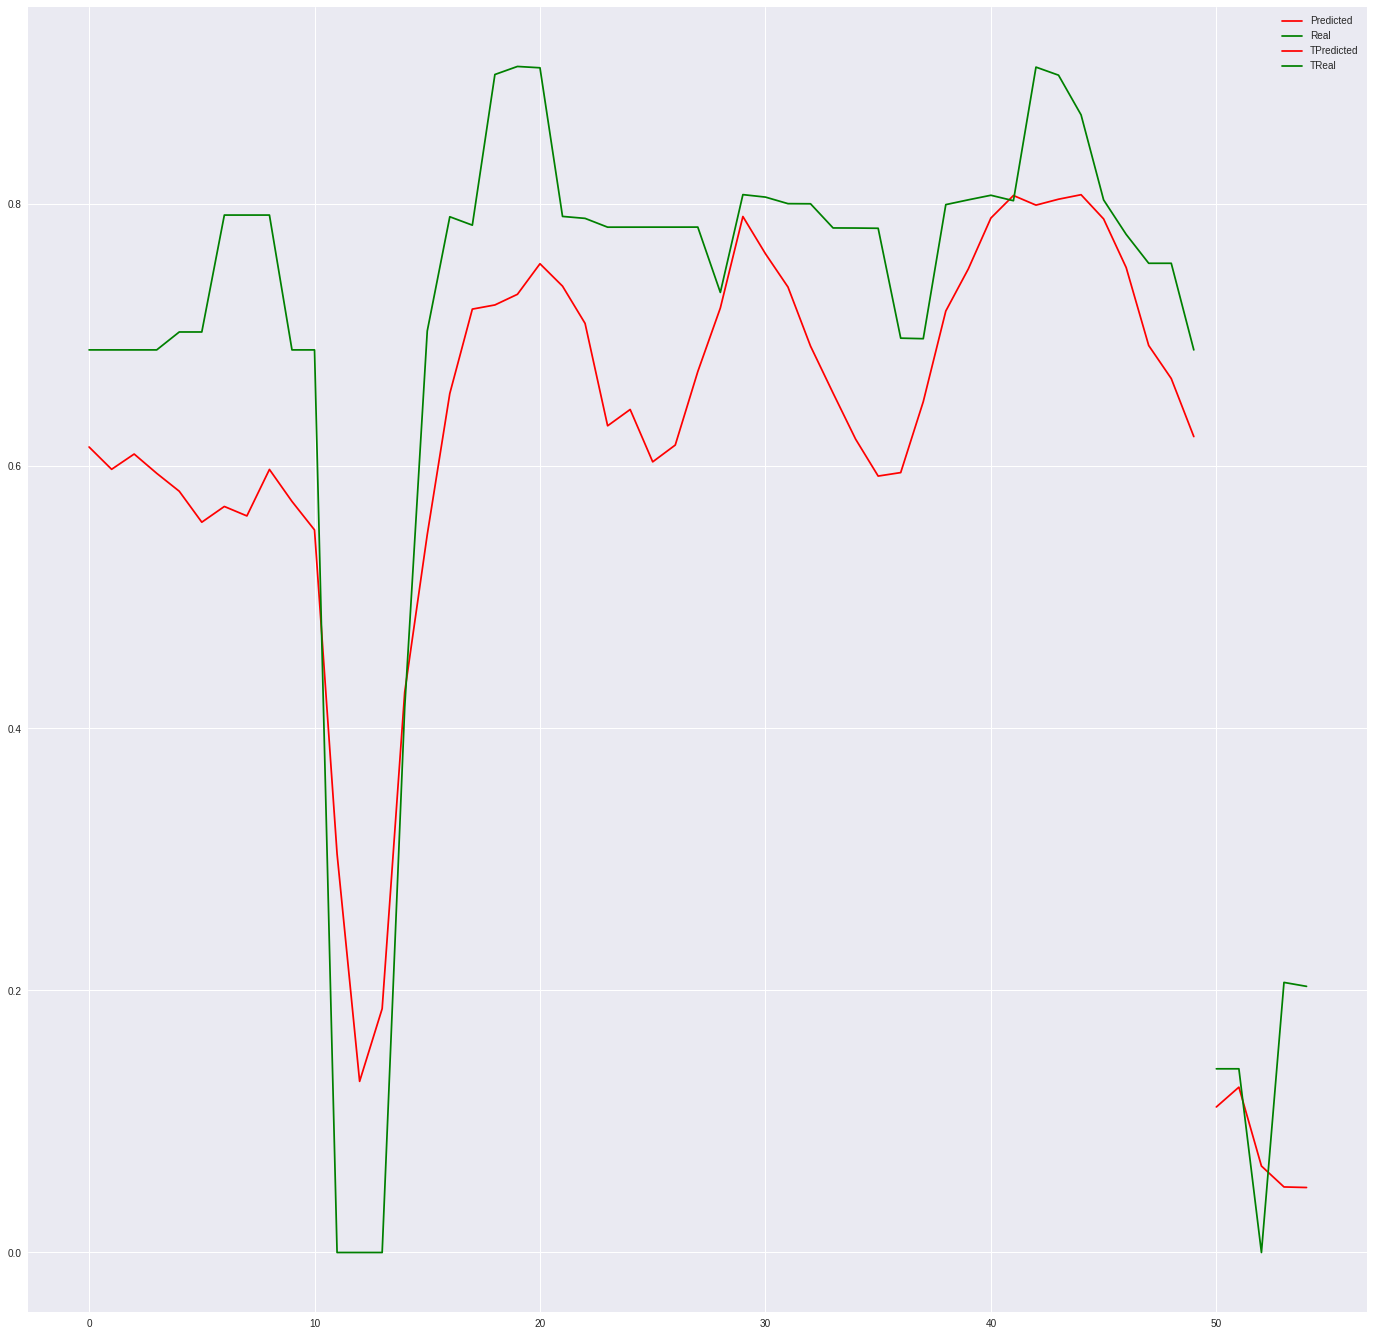

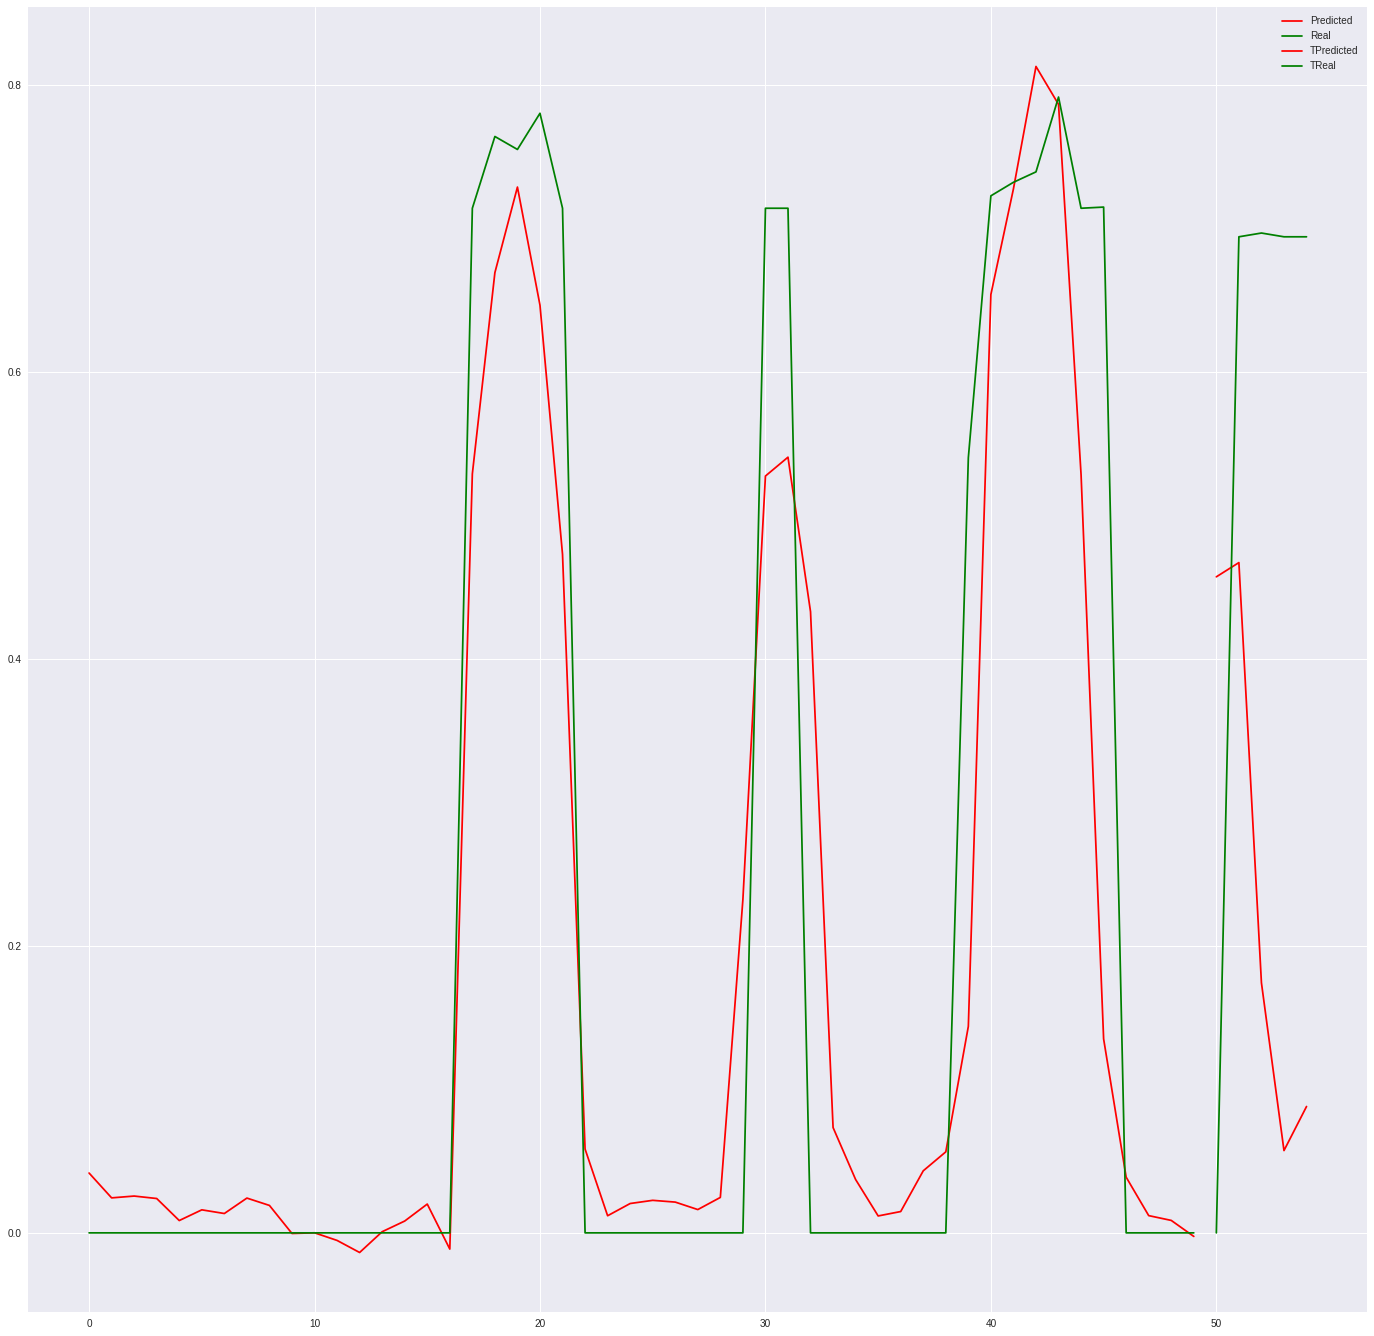

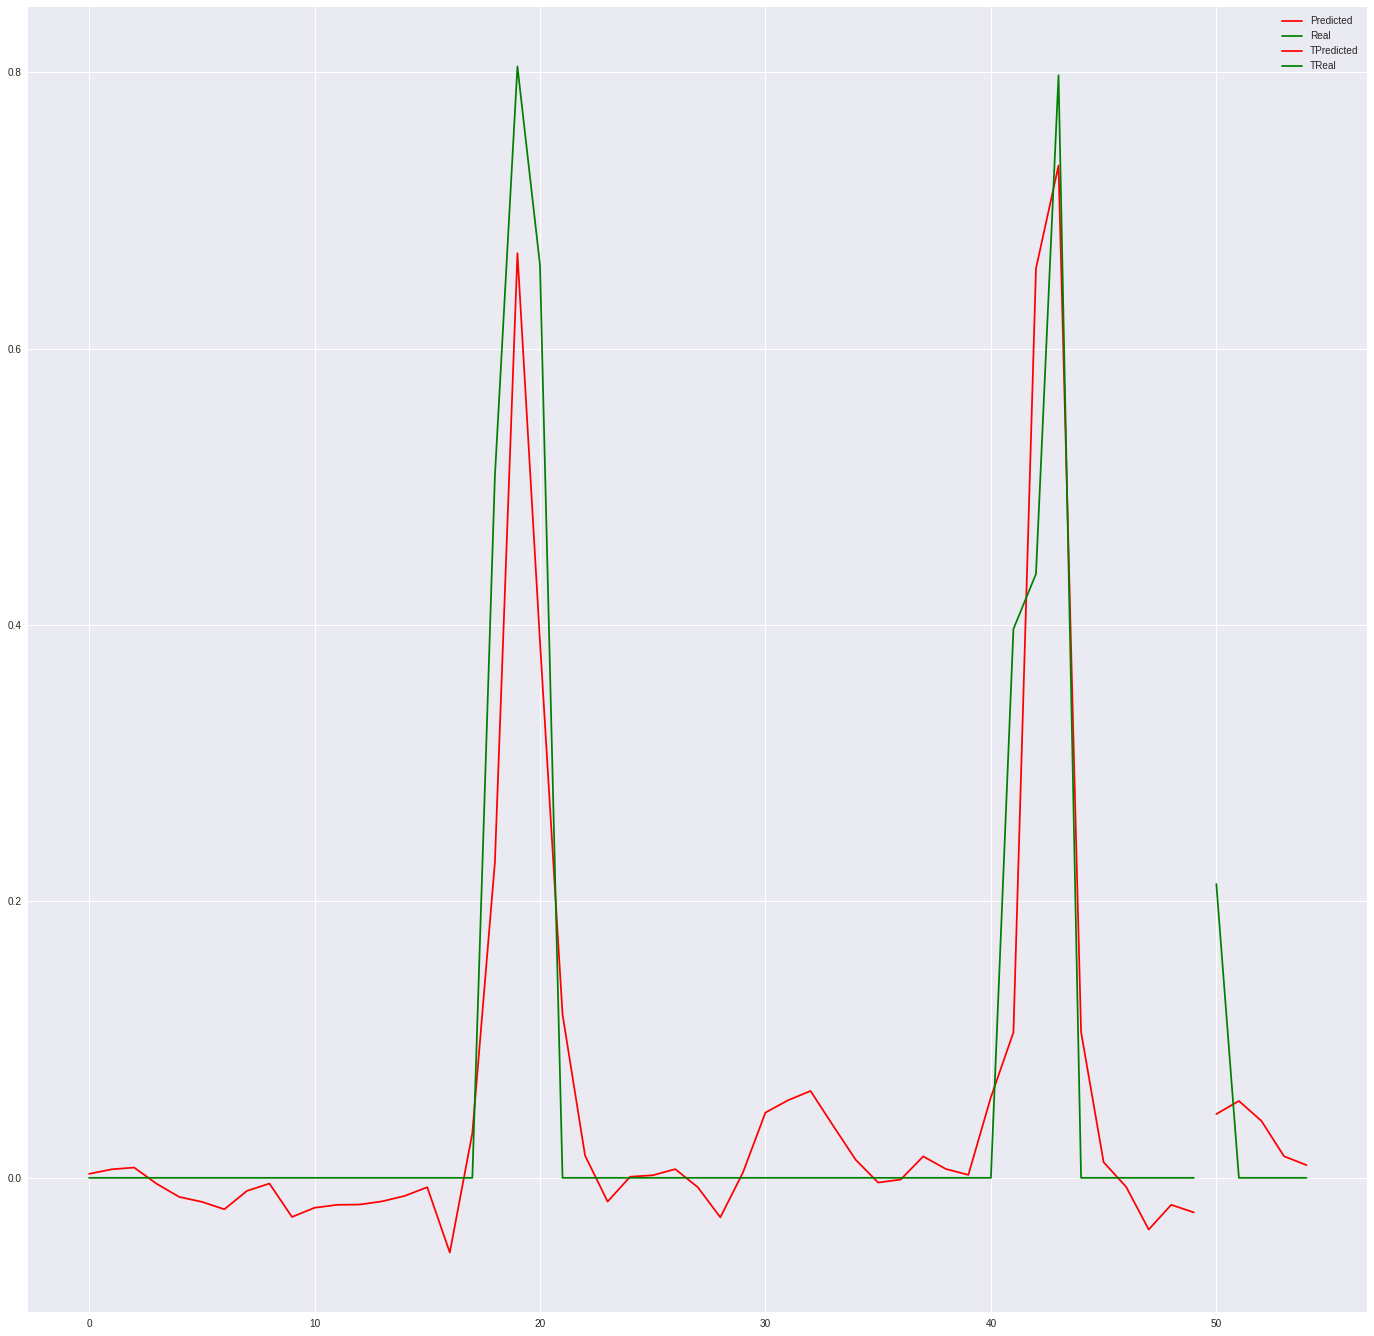

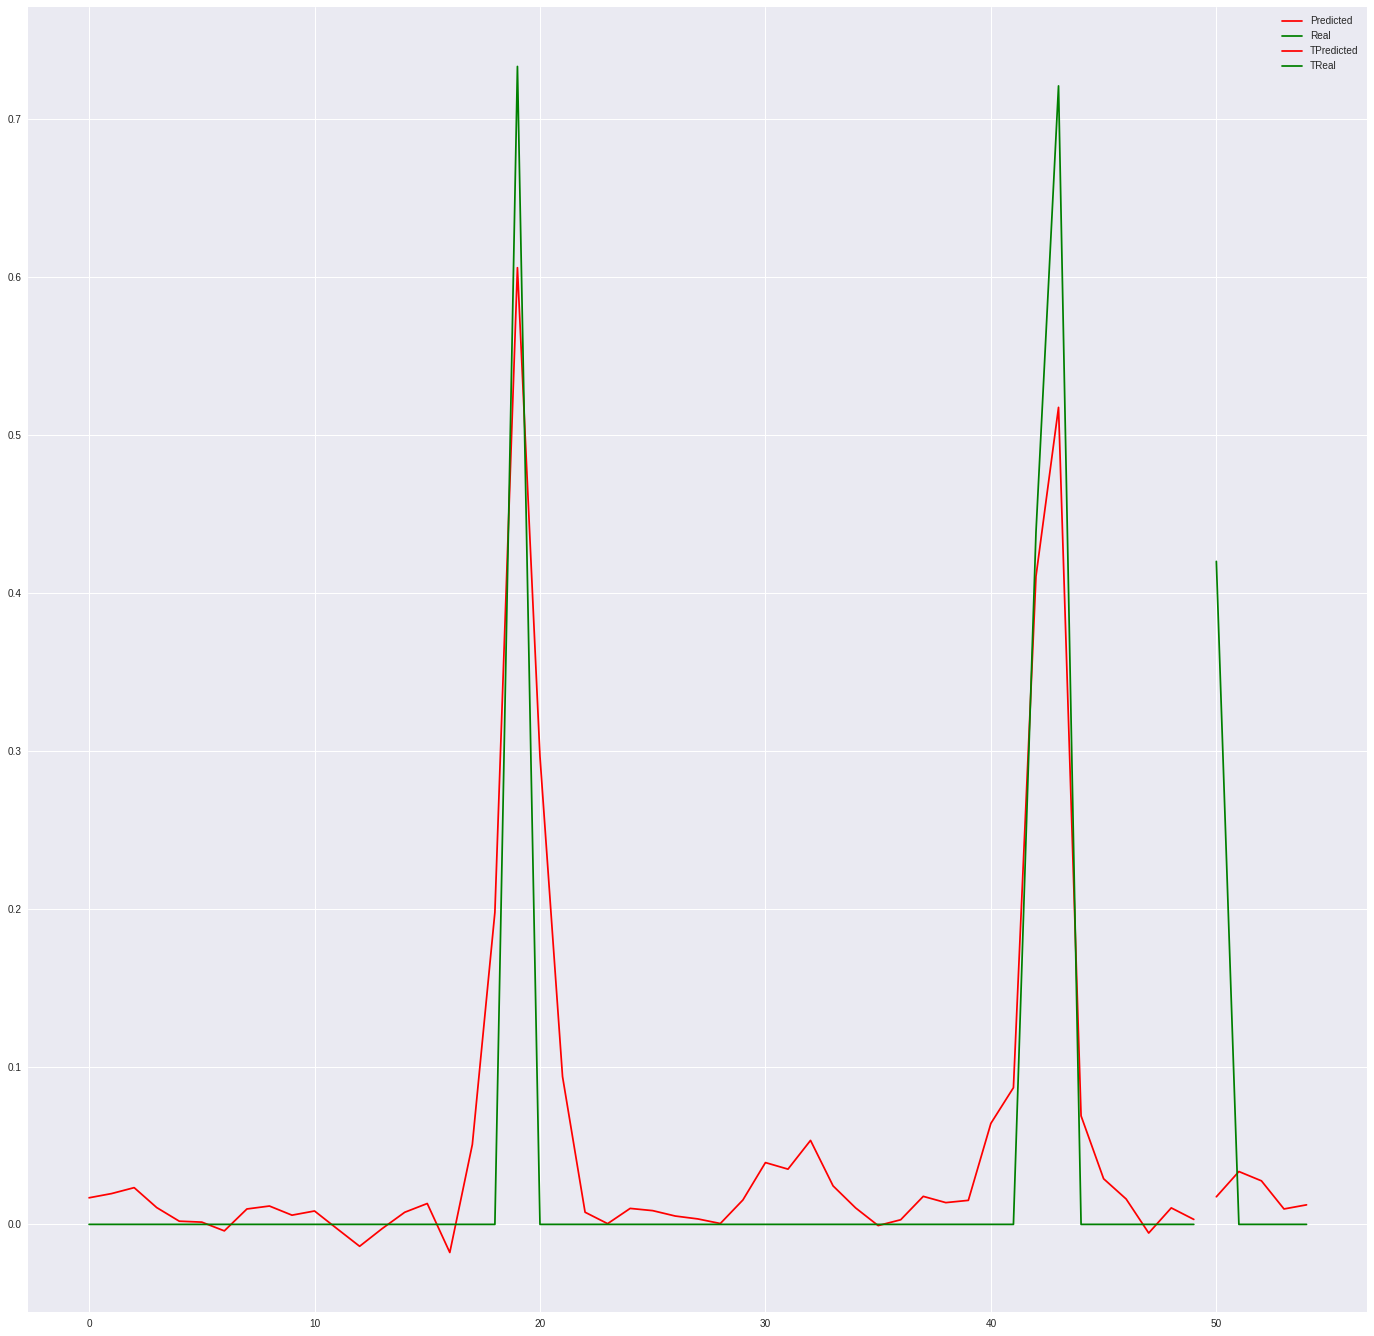

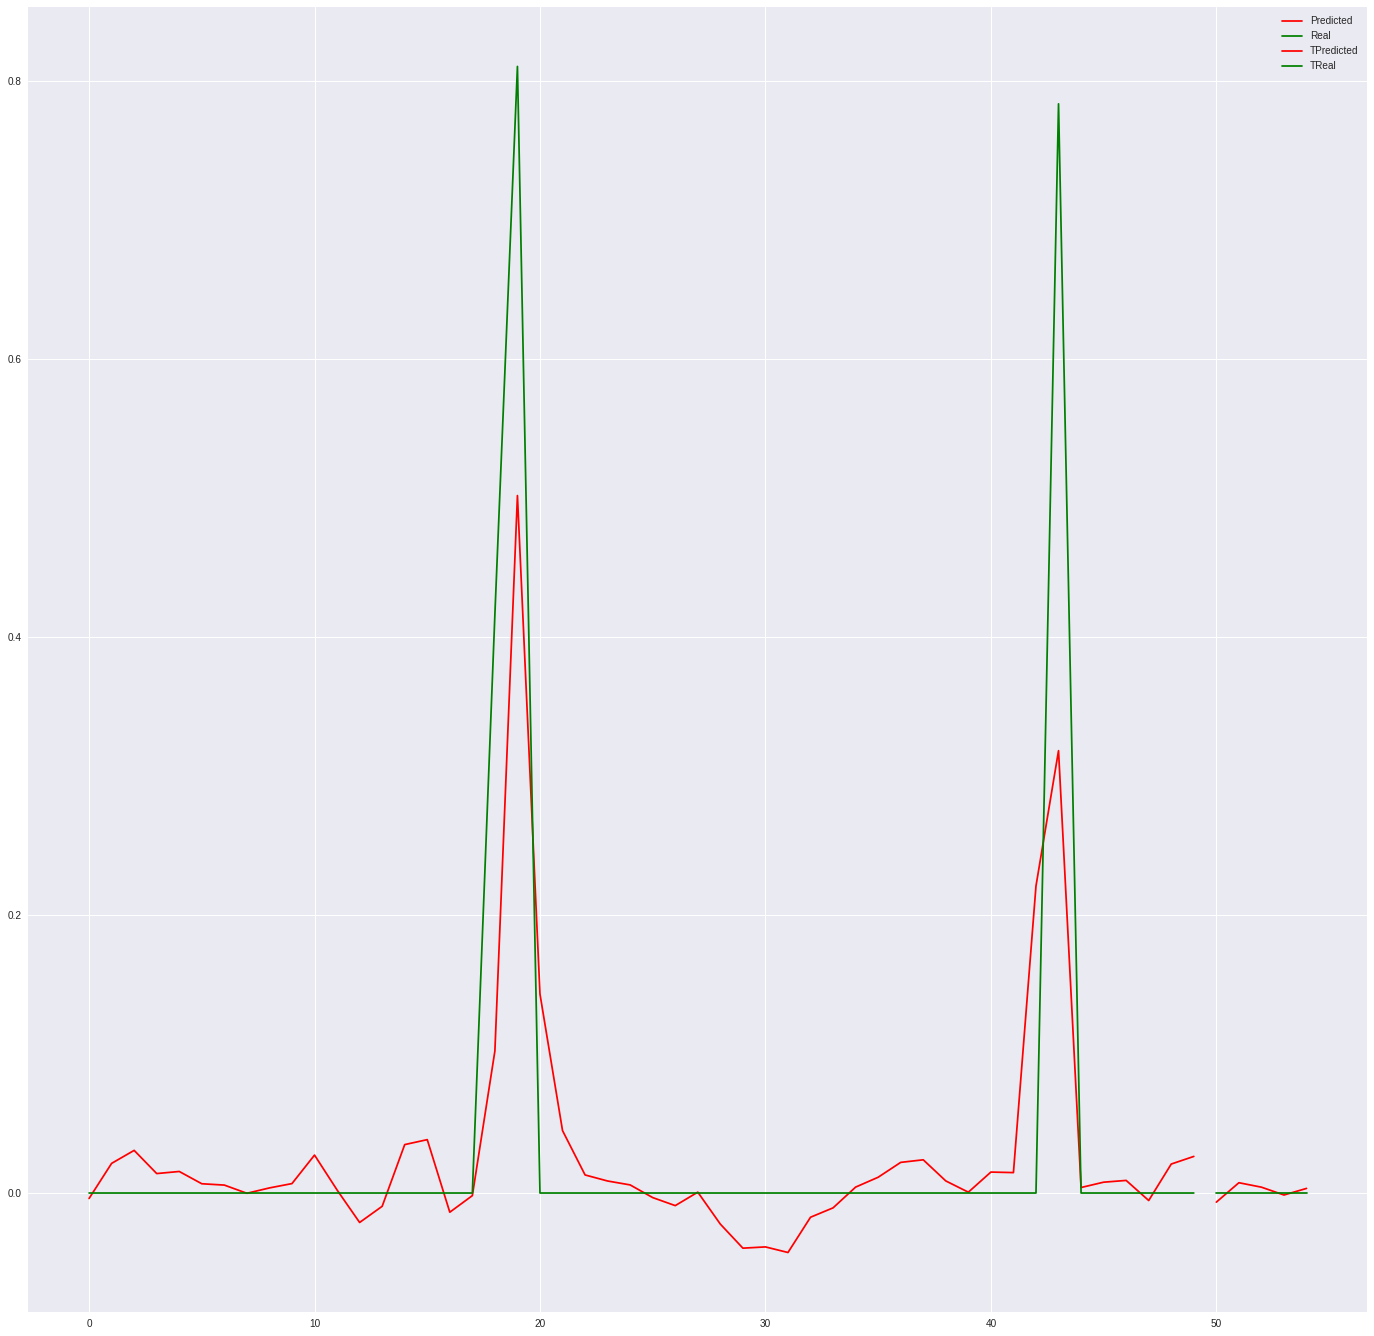

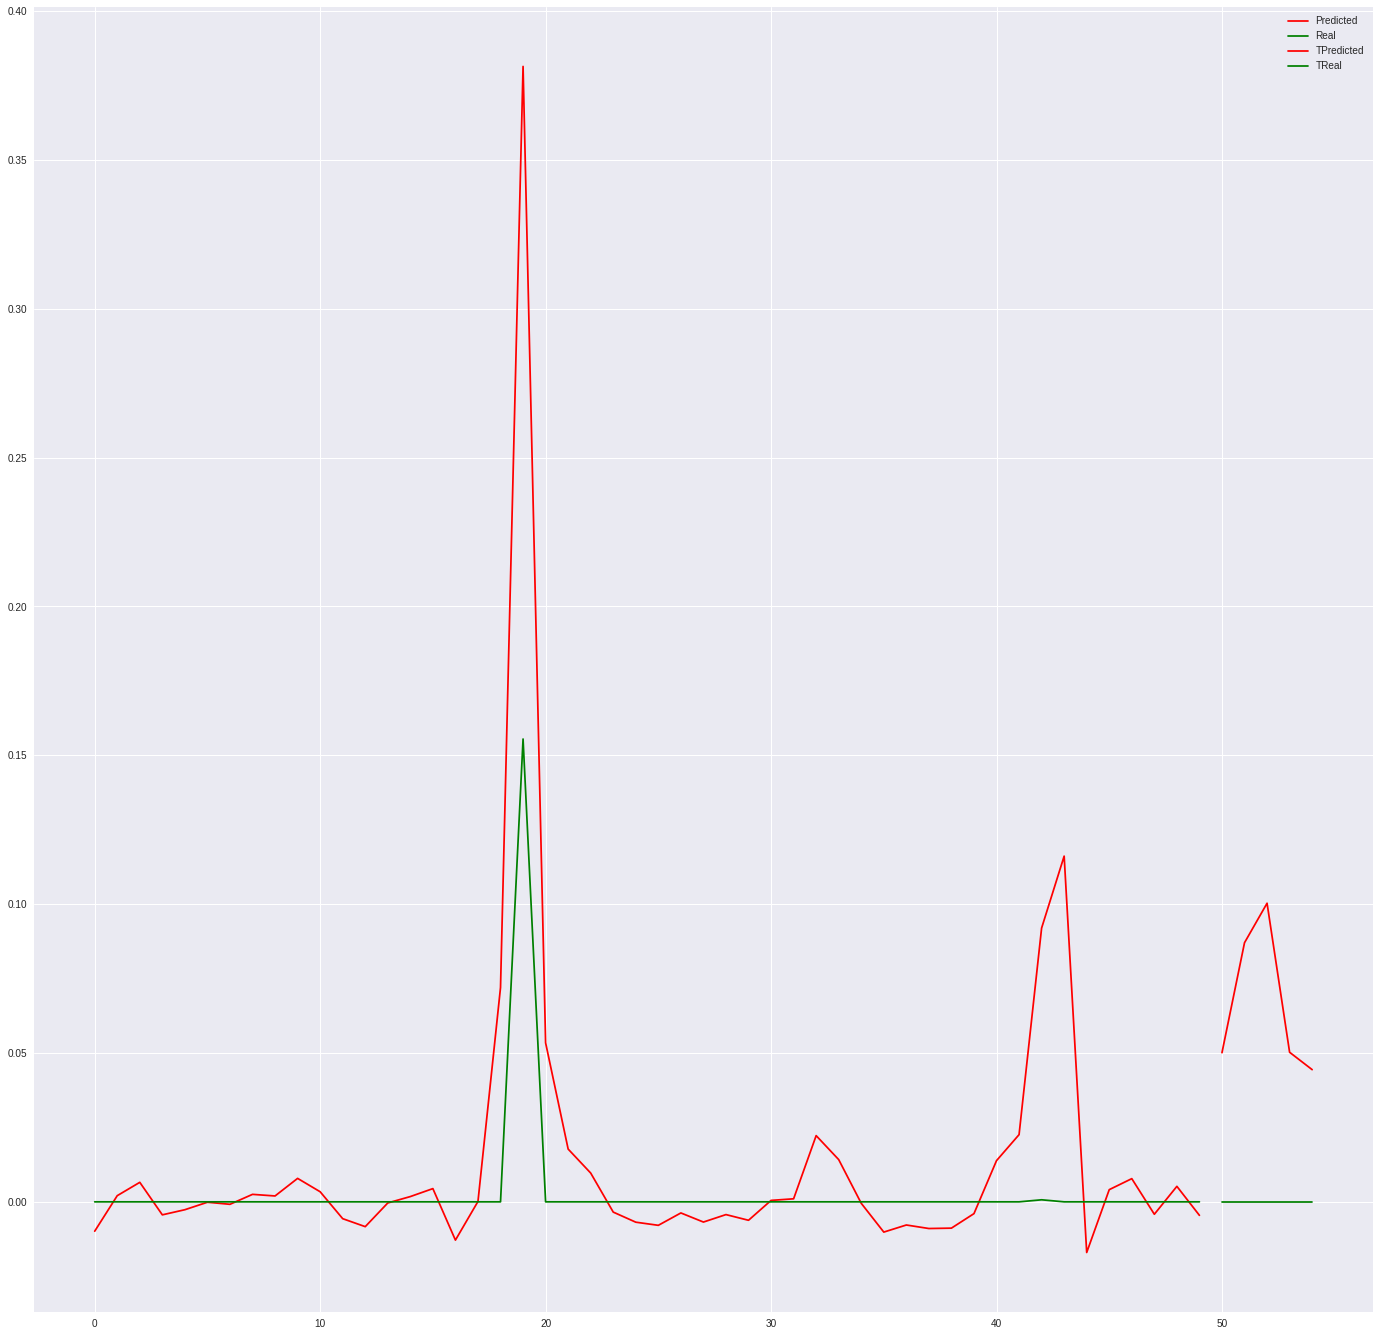

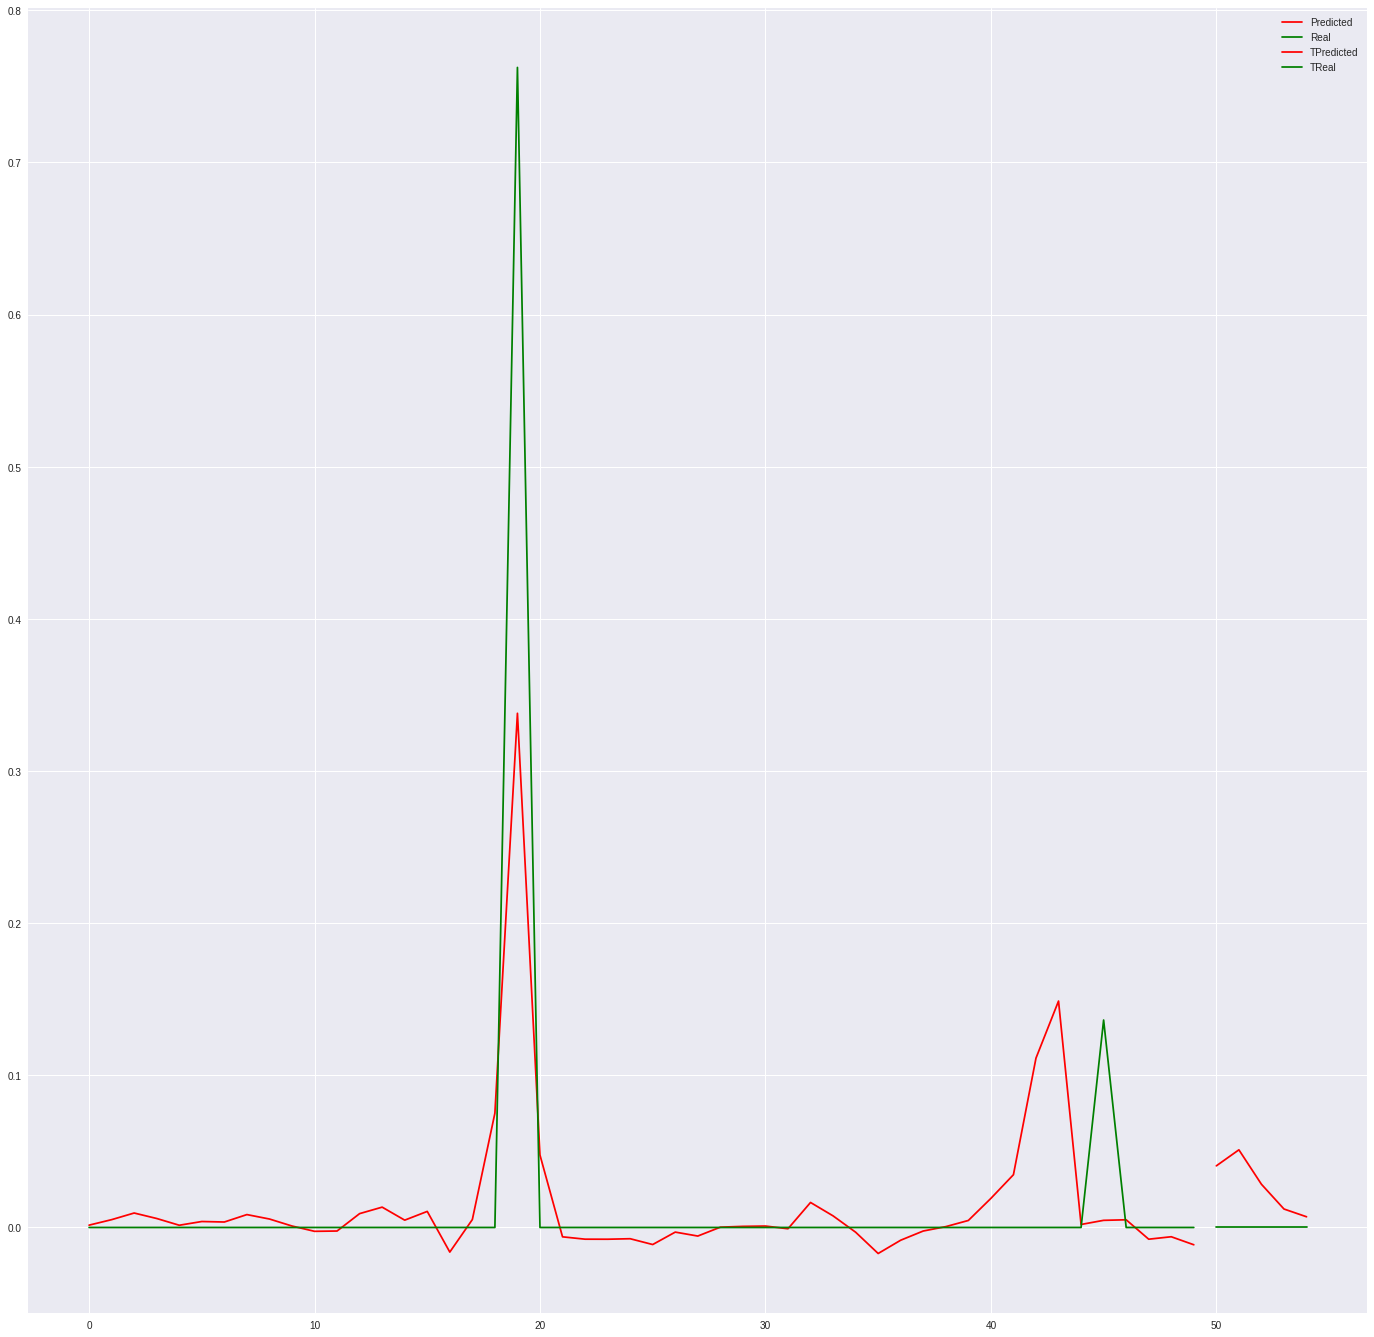

KeyboardInterrupt: ignored

In [0]:
for target_feature in range(y.shape[1]):
    ypt = unwind_y(model1.predict(Xt[:5], verbose=0), target_feature)
    yrt = unwind_y(yt[:5],target_feature)


    yp = unwind_y(model1.predict(X[50:100], verbose=0),target_feature)
    yr = unwind_y(y[50:100],target_feature)

    %matplotlib inline
    plt.figure(figsize=(24,24))
    n=100

    multi=False
    if multi:
        for i in range(10):
            plt.plot(yp[i], color= 'red', label="Predicted")
            plt.plot(yr[i], color='green', label="Real")
    else:
        plt.plot(yp, color= 'red', label="Predicted")
        plt.plot(yr, color='green', label="Real")
        plt.plot(range(len(yp),len(yp)+len(ypt)),ypt,color="red", label="TPredicted")
        plt.plot(range(len(yp),len(yp)+len(yrt)),yrt,color="green",  label="TReal")

    #plt.plot(X[50:100,n_steps-1], color='blue', label="Lagged-0")
    #plt.plot(Xt[:5,n_steps-1], color='blue', label="Lagged-0")

    plt.legend()
    plt.show()

In [0]:
y_pred_test=model1.predict(Xt)
y_pred_test.shape
#len(yt[1])

yt_arr=np.array(yt)
res=y_pred_test - yt_arr.reshape(yt_arr.shape[0],yt_arr.shape[1])

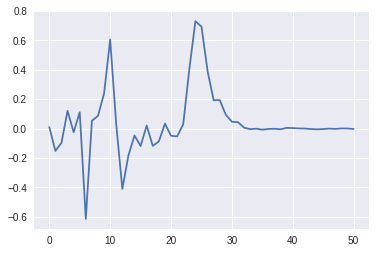

In [0]:
%matplotlib inline
plt.plot(res[0])

In [0]:
np.mean(np.power(res,2))

0.02363820671368595

[[<matplotlib.lines.Line2D at 0x7f7ccee87d30>],

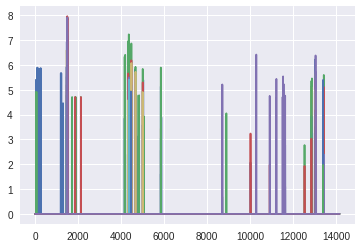

In [0]:
%matplotlib inline

[plt.plot(elem) for elem in check_list]